In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import sys
import gzip
import operator
from scipy import stats
import scipy as sp
import json
from sklearn.metrics import normalized_mutual_info_score
import community

from network_ei import *
from causal_emergence import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

# Causal Structure as a Network: Quantifying Certainty in Complex Systems

# Chapter 08: Effective Information Differences in Real Networks

Null models and real networks

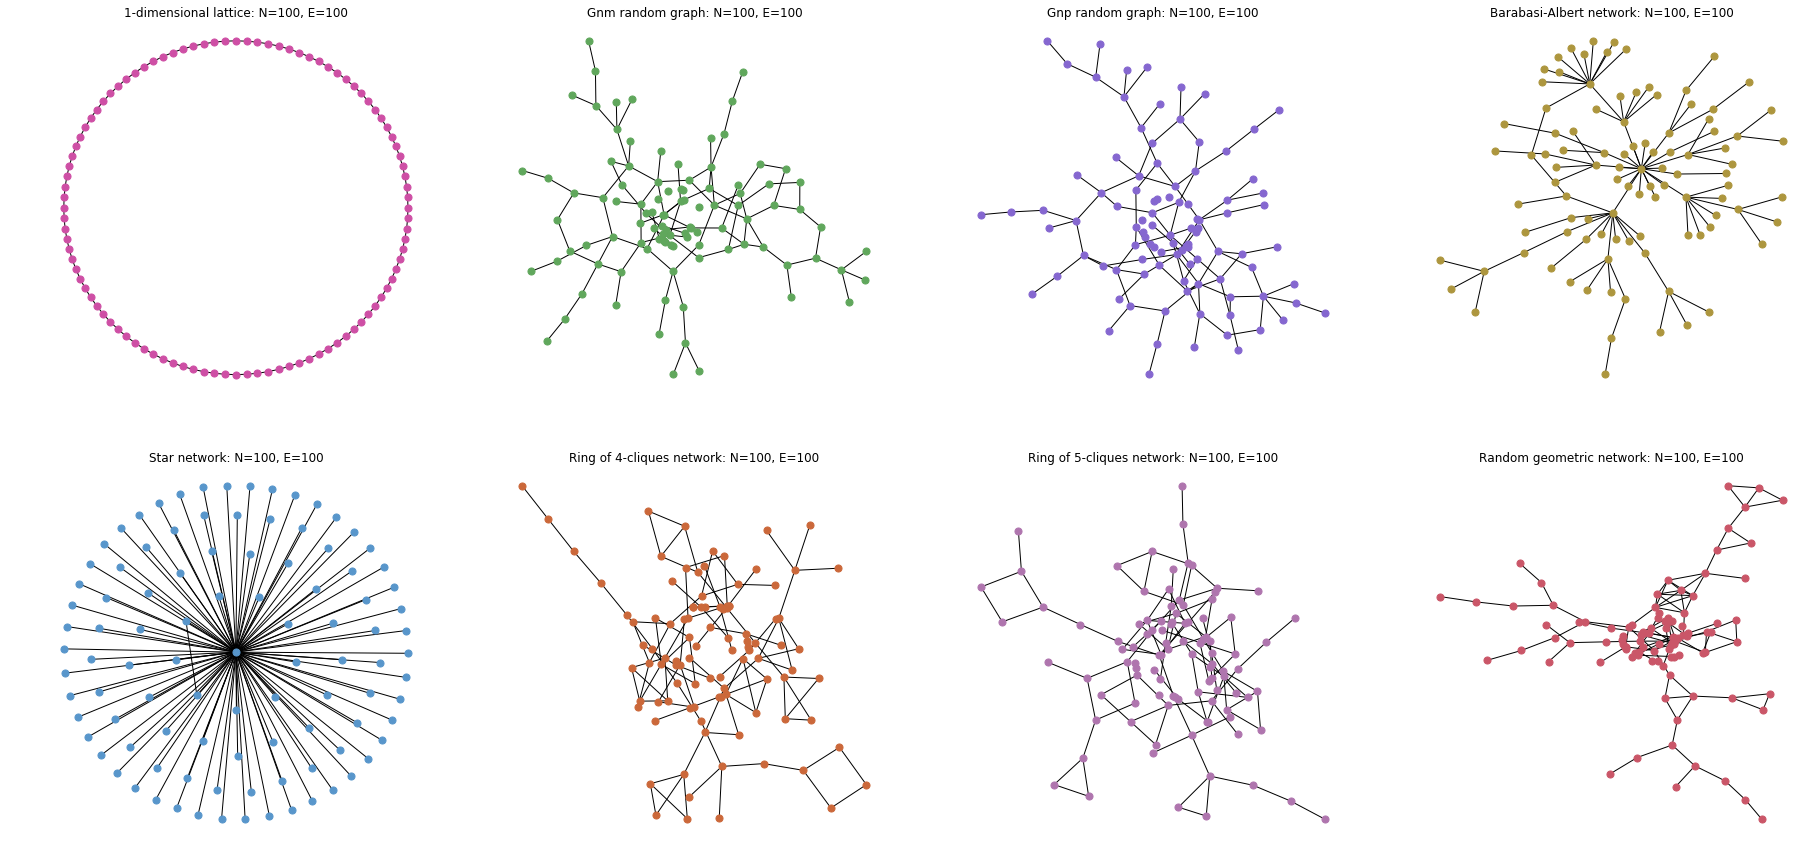

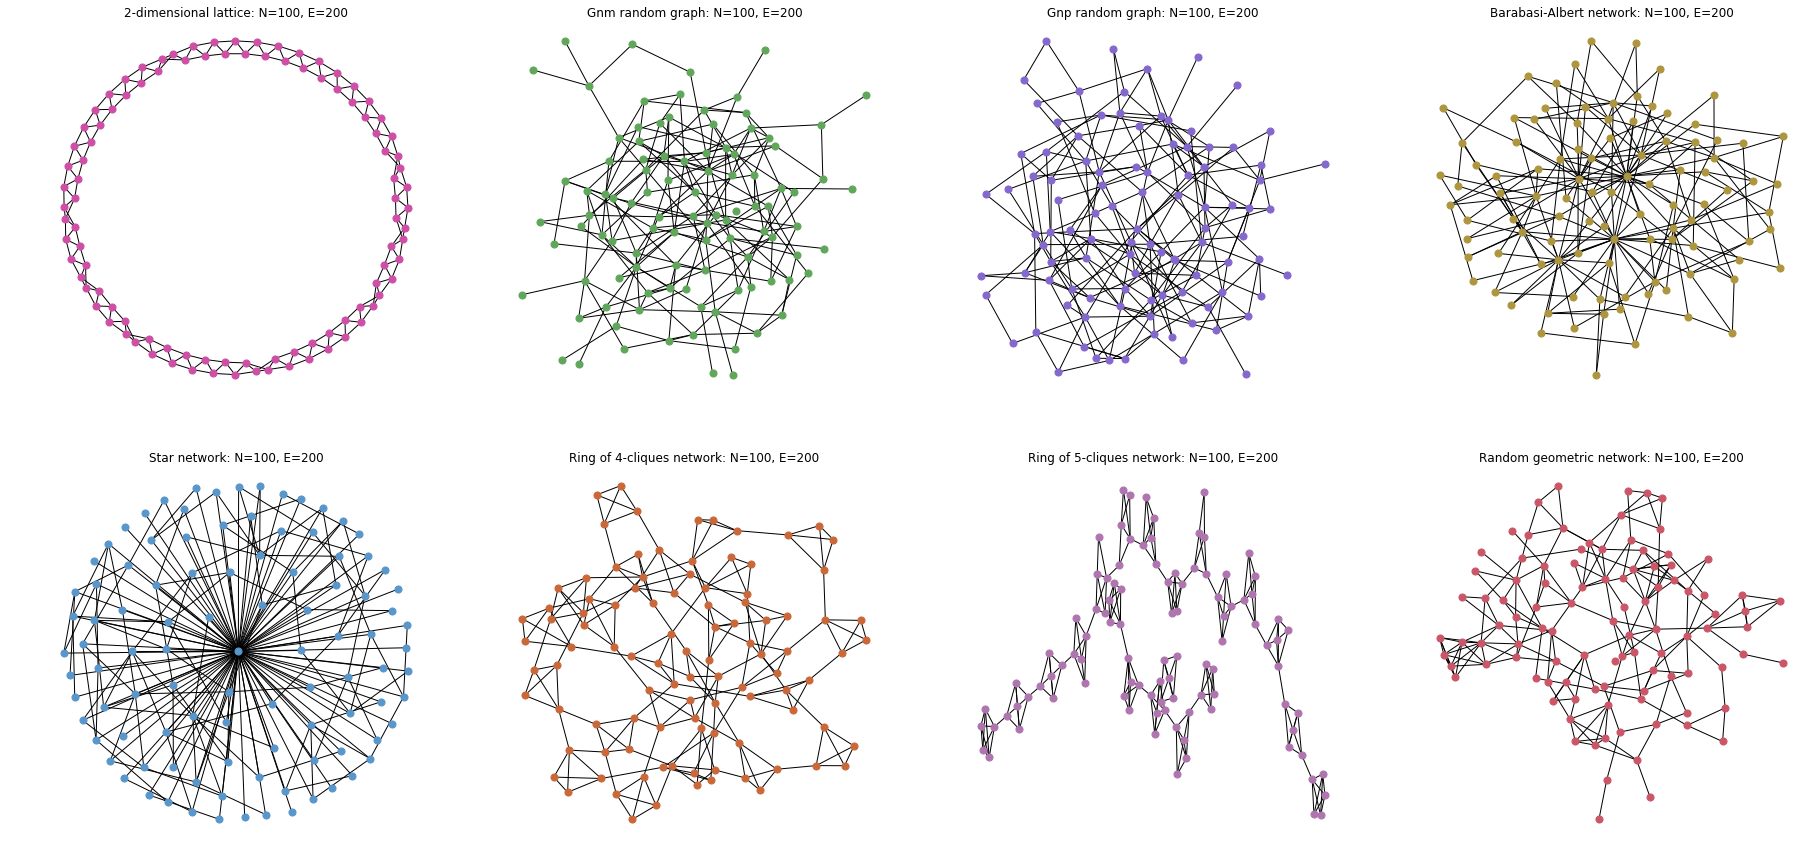

In [4]:
cols = ["#ce4fa5","#60a75c","#8567d0","#ad963e","#5896cb","#cb683a","#af75ae","#ca5668"]
list_of_graphdicts = []
N = 100
k = 2

# d-dimensional lattice
Gdd_lab = '%i-dimensional lattice'%(k/2)
Gdd = nx.watts_strogatz_graph(N, k, 0.0)
E = Gdd.number_of_edges()

# Gnm random graph
Gnm_lab = 'Gnm random graph'
Gnm = nx.gnm_random_graph(N, E)

# Gnp random graph
Gnp_lab = 'Gnp random graph'
Gnp = nx.gnp_random_graph(N, k/N)
while Gnp.number_of_edges()!= E:
    Gnp = nx.gnp_random_graph(N, k/N)

# Barabasi-Albert network
Gba_lab = 'Barabasi-Albert network'
Gba = nx.barabasi_albert_graph(N, int(k/2))
for i in range((E-Gba.number_of_edges())):
    eij = np.random.choice(list(Gba.nodes()), 2, replace=False)
    while eij in Gba.edges():
        eij = np.random.choice(list(Gba.nodes()), 2, replace=False)
    Gba.add_edge(eij[0], eij[1])

# Star network
Gst_lab = 'Star network'
Gst = nx.star_graph(N-1)
eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
while eij in Gst.edges():
    eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
Gst.add_edge(eij[0], eij[1])

# Ring of 4-cliques network
clique_size = 4
Gr4_lab = 'Ring of %i-cliques network'%clique_size
n_cliques = int(N / clique_size)
Gr4 = nx.ring_of_cliques(n_cliques, clique_size)
if E-Gr4.number_of_edges()+1 > 0:
    for i in range((E-Gr4.number_of_edges())):
        eij = np.random.choice(list(Gr4.nodes()), 2, replace=False)
        while eij in Gr4.edges():
            eij = np.random.choice(list(Gr4.nodes()), 2, replace=False)
        Gr4.add_edge(eij[0], eij[1])
if E-Gr4.number_of_edges()+1 < 0:
    for i in range((Gr4.number_of_edges()-E)):
        eij = np.random.choice(list(range(len(Gr4.edges()))))
        Gr4.remove_edge(list(Gr4.edges())[eij][0],list(Gr4.edges())[eij][1])
    
# Ring of 5-cliques network
clique_size = 5
Gr5_lab = 'Ring of %i-cliques network'%clique_size
n_cliques = int(N / clique_size)
Gr5 = nx.ring_of_cliques(n_cliques, clique_size)
if E-Gr5.number_of_edges()+1 > 0:
    for i in range((E-Gr5.number_of_edges()+1)):
        eij = np.random.choice(list(Gr5.nodes()), 2, replace=False)
        while eij in Gr5.edges():
            eij = np.random.choice(list(Gr5.nodes()), 2, replace=False)
        Gr5.add_edge(eij[0], eij[1])

if E-Gr5.number_of_edges()+1 < 0:
    for i in range((Gr5.number_of_edges()-E)):
        eij = np.random.choice(list(range(len(Gr5.edges()))))
        Gr5.remove_edge(list(Gr5.edges())[eij][0],list(Gr5.edges())[eij][1])

# Random geometric graph 
Grg_lab = 'Random geometric network'
hi = 1.0/k
lo = 1.0/N
num = 75
dist = np.linspace(lo, hi, num)
Grg_curr = nx.random_geometric_graph(N, lo/2)
for p in dist:
    Grg = Grg_curr.copy()
    Grg_curr = nx.random_geometric_graph(N, p)
    if Grg_curr.number_of_edges() > E:
        break
if E-Grg.number_of_edges()+1 > 0:
    for i in range((E-Grg.number_of_edges())):
        eij = np.random.choice(list(Grg.nodes()), 2, replace=False)
        while eij in Grg.edges():
            eij = np.random.choice(list(Grg.nodes()), 2, replace=False)
        Grg.add_edge(eij[0], eij[1])
        
h = 10
w = 21
mult = 1.5
fig, ((ax0, ax1, ax2, ax3),(ax4, ax5, ax6, ax7)) = plt.subplots(2, 4, figsize=(w*mult, h*mult))

nx.draw_kamada_kawai(Gdd, node_size=50, node_color=cols[0], ax=ax0)
nx.draw_kamada_kawai(Gnm, node_size=50, node_color=cols[1], ax=ax1)
nx.draw_kamada_kawai(Gnp, node_size=50, node_color=cols[2], ax=ax2)
nx.draw_kamada_kawai(Gba, node_size=50, node_color=cols[3], ax=ax3)

nx.draw_kamada_kawai(Gst, node_size=50, node_color=cols[4], ax=ax4)
nx.draw_kamada_kawai(Gr4, node_size=50, node_color=cols[5], ax=ax5)
nx.draw_kamada_kawai(Gr5, node_size=50, node_color=cols[6], ax=ax6)
nx.draw_kamada_kawai(Grg, node_size=50, node_color=cols[7], ax=ax7)

ax0.set_title("%s: N=%i, E=%i"%(Gdd_lab, Gdd.number_of_nodes(), Gdd.number_of_edges()), fontsize=12)
ax1.set_title("%s: N=%i, E=%i"%(Gnm_lab, Gnm.number_of_nodes(), Gnm.number_of_edges()), fontsize=12)
ax2.set_title("%s: N=%i, E=%i"%(Gnp_lab, Gnp.number_of_nodes(), Gnp.number_of_edges()), fontsize=12)
ax3.set_title("%s: N=%i, E=%i"%(Gba_lab, Gba.number_of_nodes(), Gba.number_of_edges()), fontsize=12)
ax4.set_title("%s: N=%i, E=%i"%(Gst_lab, Gst.number_of_nodes(), Gst.number_of_edges()), fontsize=12)
ax5.set_title("%s: N=%i, E=%i"%(Gr4_lab, Gr4.number_of_nodes(), Gr4.number_of_edges()), fontsize=12)
ax6.set_title("%s: N=%i, E=%i"%(Gr5_lab, Gr5.number_of_nodes(), Gr5.number_of_edges()), fontsize=12)
ax7.set_title("%s: N=%i, E=%i"%(Grg_lab, Grg.number_of_nodes(), Grg.number_of_edges()), fontsize=12)

plt.show()

n100e100 = {Gdd_lab: Gdd,
            Gnm_lab: Gnm,
            Gnp_lab: Gnp,
            Gba_lab: Gba,
            Gst_lab: Gst,
            Gr4_lab: Gr4,
            Gr5_lab: Gr5,
            Grg_lab: Grg}
list_of_graphdicts.append(n100e100)

# N = [100, 200, 300, 400, 500]
# k = [2, 4, 6]
N = 100
k = 4

# d-dimensional lattice
Gdd_lab = '%i-dimensional lattice'%(k/2)
Gdd = nx.watts_strogatz_graph(N, k, 0.0)
E = Gdd.number_of_edges()

# Gnm random graph
Gnm_lab = 'Gnm random graph'
Gnm = nx.gnm_random_graph(N, E)

# Gnp random graph
Gnp_lab = 'Gnp random graph'
Gnp = nx.gnp_random_graph(N, k/N)
while Gnp.number_of_edges()!= E:
    Gnp = nx.gnp_random_graph(N, k/N)

# Barabasi-Albert network
Gba_lab = 'Barabasi-Albert network'
Gba = nx.barabasi_albert_graph(N, int(k/2))
for i in range((E-Gba.number_of_edges())):
    eij = np.random.choice(list(Gba.nodes()), 2, replace=False)
    while eij in Gba.edges():
        eij = np.random.choice(list(Gba.nodes()), 2, replace=False)
    Gba.add_edge(eij[0], eij[1])

# Star network
Gst_lab = 'Star network'
Gst = nx.star_graph(N-1)
eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
if E-Gst.number_of_edges()+1 > 0:
    for i in range((E-Gst.number_of_edges())):
        eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
        while eij in Gst.edges():
            eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
        Gst.add_edge(eij[0], eij[1])
if E-Gst.number_of_edges()+1 < 0:
    for i in range((Gst.number_of_edges()-E)):
        eij = np.random.choice(list(range(len(Gst.edges()))))
        Gst.remove_edge(list(Gst.edges())[eij][0],list(Gst.edges())[eij][1])

# Ring of 4-cliques network
clique_size = 4
Gr4_lab = 'Ring of %i-cliques network'%clique_size
n_cliques = int(N / clique_size)
Gr4 = nx.ring_of_cliques(n_cliques, clique_size)
if E-Gr4.number_of_edges()+1 > 0:
    for i in range((E-Gr4.number_of_edges())):
        eij = np.random.choice(list(Gr4.nodes()), 2, replace=False)
        while eij in Gr4.edges():
            eij = np.random.choice(list(Gr4.nodes()), 2, replace=False)
        Gr4.add_edge(eij[0], eij[1])
if E-Gr4.number_of_edges()+1 < 0:
    for i in range((Gr4.number_of_edges()-E)):
        eij = np.random.choice(list(range(len(Gr4.edges()))))
        Gr4.remove_edge(list(Gr4.edges())[eij][0],list(Gr4.edges())[eij][1])
    
# Ring of 5-cliques network
clique_size = 5
Gr5_lab = 'Ring of %i-cliques network'%clique_size
n_cliques = int(N / clique_size)
Gr5 = nx.ring_of_cliques(n_cliques, clique_size)
if E-Gr5.number_of_edges()+1 > 0:
    for i in range((E-Gr5.number_of_edges()+1)):
        eij = np.random.choice(list(Gr5.nodes()), 2, replace=False)
        while eij in Gr5.edges():
            eij = np.random.choice(list(Gr5.nodes()), 2, replace=False)
        Gr5.add_edge(eij[0], eij[1])

if E-Gr5.number_of_edges()+1 < 0:
    for i in range((Gr5.number_of_edges()-E)):
        eij = np.random.choice(list(range(len(Gr5.edges()))))
        Gr5.remove_edge(list(Gr5.edges())[eij][0],list(Gr5.edges())[eij][1])

# Random geometric graph 
Grg_lab = 'Random geometric network'
hi = 1.0/k
lo = 1.0/N
num = 75
dist = np.linspace(lo, hi, num)
Grg_curr = nx.random_geometric_graph(N, lo/2)
for p in dist:
    Grg = Grg_curr.copy()
    Grg_curr = nx.random_geometric_graph(N, p)
    if Grg_curr.number_of_edges() > E:
        break
if E-Grg.number_of_edges()+1 > 0:
    for i in range((E-Grg.number_of_edges())):
        eij = np.random.choice(list(Grg.nodes()), 2, replace=False)
        while eij in Grg.edges():
            eij = np.random.choice(list(Grg.nodes()), 2, replace=False)
        Grg.add_edge(eij[0], eij[1])
        
h = 10
w = 21
mult = 1.5
fig, ((ax0, ax1, ax2, ax3),(ax4, ax5, ax6, ax7)) = plt.subplots(2, 4, figsize=(w*mult, h*mult))

nx.draw_kamada_kawai(Gdd, node_size=50, node_color=cols[0], ax=ax0)
nx.draw_kamada_kawai(Gnm, node_size=50, node_color=cols[1], ax=ax1)
nx.draw_kamada_kawai(Gnp, node_size=50, node_color=cols[2], ax=ax2)
nx.draw_kamada_kawai(Gba, node_size=50, node_color=cols[3], ax=ax3)

nx.draw_kamada_kawai(Gst, node_size=50, node_color=cols[4], ax=ax4)
nx.draw_kamada_kawai(Gr4, node_size=50, node_color=cols[5], ax=ax5)
nx.draw_kamada_kawai(Gr5, node_size=50, node_color=cols[6], ax=ax6)
nx.draw_kamada_kawai(Grg, node_size=50, node_color=cols[7], ax=ax7)

ax0.set_title("%s: N=%i, E=%i"%(Gdd_lab, Gdd.number_of_nodes(), Gdd.number_of_edges()), fontsize=12)
ax1.set_title("%s: N=%i, E=%i"%(Gnm_lab, Gnm.number_of_nodes(), Gnm.number_of_edges()), fontsize=12)
ax2.set_title("%s: N=%i, E=%i"%(Gnp_lab, Gnp.number_of_nodes(), Gnp.number_of_edges()), fontsize=12)
ax3.set_title("%s: N=%i, E=%i"%(Gba_lab, Gba.number_of_nodes(), Gba.number_of_edges()), fontsize=12)
ax4.set_title("%s: N=%i, E=%i"%(Gst_lab, Gst.number_of_nodes(), Gst.number_of_edges()), fontsize=12)
ax5.set_title("%s: N=%i, E=%i"%(Gr4_lab, Gr4.number_of_nodes(), Gr4.number_of_edges()), fontsize=12)
ax6.set_title("%s: N=%i, E=%i"%(Gr5_lab, Gr5.number_of_nodes(), Gr5.number_of_edges()), fontsize=12)
ax7.set_title("%s: N=%i, E=%i"%(Grg_lab, Grg.number_of_nodes(), Grg.number_of_edges()), fontsize=12)

plt.show()

n100e400 = {Gdd_lab: Gdd,
            Gnm_lab: Gnm,
            Gnp_lab: Gnp,
            Gba_lab: Gba,
            Gst_lab: Gst,
            Gr4_lab: Gr4,
            Gr5_lab: Gr5,
            Grg_lab: Grg}

list_of_graphdicts.append(n100e400)

______________

In [5]:
p0 = 0.0
graph_names = ['d-dimensional lattice', 
               'Gnm random graph', 
               'Gnp random graph', 
               'Barabasi-Albert network', 
               'Star network', 
               'Ring of 4-cliques network', 
               'Ring of 5-cliques network', 
               'Random geometric network']

dd = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
nm = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
er = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
ba = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
st = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
r4 = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
r5 = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}
rg = {'determinism':[], 'degeneracy':[], 'ei':[],'N':[], 'E':[], 'k':[], 'G':[]}

list_of_graphdicts = []
Ns = [100, 500, 1000]
# ks = [2]
ks = [2, 4, 6]
for N in Ns:
    for k in ks:
        # d-dimensional lattice
        Gdd_lab = '%i-dimensional lattice'%(k/2)
        Gdd = nx.watts_strogatz_graph(N, k, 0.0)
        E = Gdd.number_of_edges()
        dd['N'].append(Gdd.number_of_nodes())
        dd['E'].append(Gdd.number_of_edges())
        dd['k'].append(k)
        dd['determinism'].append(get_determinism(Gdd, p0))
        dd['degeneracy'].append(get_degeneracy(Gdd, p0))
        dd['ei'].append(get_ei(Gdd, p0))
        dd['G'].append(Gdd)
        
        # Gnm random graph
        Gnm_lab = 'Gnm random graph'
        Gnm = nx.gnm_random_graph(N, E)
        nm['N'].append(Gnm.number_of_nodes())
        nm['E'].append(Gnm.number_of_edges())
        nm['k'].append(k)
        nm['determinism'].append(get_determinism(Gnm, p0))
        nm['degeneracy'].append(get_degeneracy(Gnm, p0))
        nm['ei'].append(get_ei(Gnm, p0))
        nm['G'].append(Gnm)

        # Gnp random graph
        Gnp_lab = 'Gnp random graph'
        Gnp = nx.gnp_random_graph(N, k/N)
        while Gnp.number_of_edges()!= E:
            Gnp = nx.gnp_random_graph(N, k/N)
        er['N'].append(Gnp.number_of_nodes())
        er['E'].append(Gnp.number_of_edges())
        er['k'].append(k)
        er['determinism'].append(get_determinism(Gnp, p0))
        er['degeneracy'].append(get_degeneracy(Gnp, p0))
        er['ei'].append(get_ei(Gnp, p0))
        er['G'].append(Gnp)

        # Barabasi-Albert network
        Gba_lab = 'Barabasi-Albert network'
        Gba = nx.barabasi_albert_graph(N, int(k/2))
        for i in range((E-Gba.number_of_edges())):
            eij = np.random.choice(list(Gba.nodes()), 2, replace=False)
            while eij in Gba.edges():
                eij = np.random.choice(list(Gba.nodes()), 2, replace=False)
            Gba.add_edge(eij[0], eij[1])
        ba['N'].append(Gba.number_of_nodes())
        ba['E'].append(Gba.number_of_edges())
        ba['k'].append(k)
        ba['determinism'].append(get_determinism(Gba, p0))
        ba['degeneracy'].append(get_degeneracy(Gba, p0))
        ba['ei'].append(get_ei(Gba, p0))
        ba['G'].append(Gba)

        # Star network
        Gst_lab = 'Star network'
        Gst = nx.star_graph(N-1)
        eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
        if E-Gst.number_of_edges()+1 > 0:
            for i in range((E-Gst.number_of_edges())):
                eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
                while eij in Gst.edges():
                    eij = np.random.choice(list(Gst.nodes()), 2, replace=False)
                Gst.add_edge(eij[0], eij[1])
        if E-Gst.number_of_edges()+1 < 0:
            for i in range((Gst.number_of_edges()-E)):
                eij = np.random.choice(list(range(len(Gst.edges()))))
                Gst.remove_edge(list(Gst.edges())[eij][0],list(Gst.edges())[eij][1])
        st['N'].append(Gst.number_of_nodes())
        st['E'].append(Gst.number_of_edges())
        st['k'].append(k)
        st['determinism'].append(get_determinism(Gst, p0))
        st['degeneracy'].append(get_degeneracy(Gst, p0))
        st['ei'].append(get_ei(Gst, p0))
        st['G'].append(Gst)

        # Ring of 4-cliques network
        clique_size = 4
        Gr4_lab = 'Ring of %i-cliques network'%clique_size
        n_cliques = int(N / clique_size)
        Gr4 = nx.ring_of_cliques(n_cliques, clique_size)
        if E-Gr4.number_of_edges()+1 > 0:
            for i in range((E-Gr4.number_of_edges())):
                eij = np.random.choice(list(Gr4.nodes()), 2, replace=False)
                while eij in Gr4.edges():
                    eij = np.random.choice(list(Gr4.nodes()), 2, replace=False)
                Gr4.add_edge(eij[0], eij[1])
        if E-Gr4.number_of_edges()+1 < 0:
            for i in range((Gr4.number_of_edges()-E)):
                eij = np.random.choice(list(range(len(Gr4.edges()))))
                Gr4.remove_edge(list(Gr4.edges())[eij][0],list(Gr4.edges())[eij][1])
        r4['N'].append(Gr4.number_of_nodes())
        r4['E'].append(Gr4.number_of_edges())
        r4['k'].append(k)
        r4['determinism'].append(get_determinism(Gr4, p0))
        r4['degeneracy'].append(get_degeneracy(Gr4, p0))
        r4['ei'].append(get_ei(Gr4, p0))
        r4['G'].append(Gr4)
        
        # Ring of 5-cliques network
        clique_size = 5
        Gr5_lab = 'Ring of %i-cliques network'%clique_size
        n_cliques = int(N / clique_size)
        Gr5 = nx.ring_of_cliques(n_cliques, clique_size)
        if E-Gr5.number_of_edges()+1 > 0:
            for i in range((E-Gr5.number_of_edges()+1)):
                eij = np.random.choice(list(Gr5.nodes()), 2, replace=False)
                while eij in Gr5.edges():
                    eij = np.random.choice(list(Gr5.nodes()), 2, replace=False)
                Gr5.add_edge(eij[0], eij[1])
        if E-Gr5.number_of_edges() < 0:
            for i in range((Gr5.number_of_edges()-E)):
                eij = np.random.choice(list(range(len(Gr5.edges()))))
                Gr5.remove_edge(list(Gr5.edges())[eij][0],list(Gr5.edges())[eij][1])
        r5['N'].append(Gr5.number_of_nodes())
        r5['E'].append(Gr5.number_of_edges())
        r5['k'].append(k)
        r5['determinism'].append(get_determinism(Gr5, p0))
        r5['degeneracy'].append(get_degeneracy(Gr5, p0))
        r5['ei'].append(get_ei(Gr5, p0))
        r5['G'].append(Gr5)

        # Random geometric graph 
        Grg_lab = 'Random geometric network'
        hi = 1.0/k
        lo = 1.0/N
        num = 75
        dist = np.linspace(lo, hi, num)
        Grg_curr = nx.random_geometric_graph(N, lo/2)
        for p in dist:
            Grg = Grg_curr.copy()
            Grg_curr = nx.random_geometric_graph(N, p)
            if Grg_curr.number_of_edges() > E:
                break
        if E-Grg.number_of_edges()+1 > 0:
            for i in range((E-Grg.number_of_edges())):
                eij = np.random.choice(list(Grg.nodes()), 2, replace=False)
                while eij in Grg.edges():
                    eij = np.random.choice(list(Grg.nodes()), 2, replace=False)
                Grg.add_edge(eij[0], eij[1])
        rg['N'].append(Grg.number_of_nodes())
        rg['E'].append(Grg.number_of_edges())
        rg['k'].append(k)
        rg['determinism'].append(get_determinism(Grg, p0))
        rg['degeneracy'].append(get_degeneracy(Grg, p0))
        rg['ei'].append(get_ei(Grg, p0))
        rg['G'].append(Grg)

list_of_graphdicts.append(dd)
list_of_graphdicts.append(nm)
list_of_graphdicts.append(er)
list_of_graphdicts.append(ba)
list_of_graphdicts.append(st)
list_of_graphdicts.append(r4)
list_of_graphdicts.append(r5)
list_of_graphdicts.append(rg)

graph_dict = dict(zip(graph_names, list_of_graphdicts))

In [6]:
cols = ["#ce4fa5","#60a75c","#8567d0","#ad963e","#5896cb","#cb683a","#af75ae","#ca5668"]

In [7]:
deg_shape = {2:'h', 4:'s', 6:'^'}
num_size = {100:6, 500:13, 1000:23}

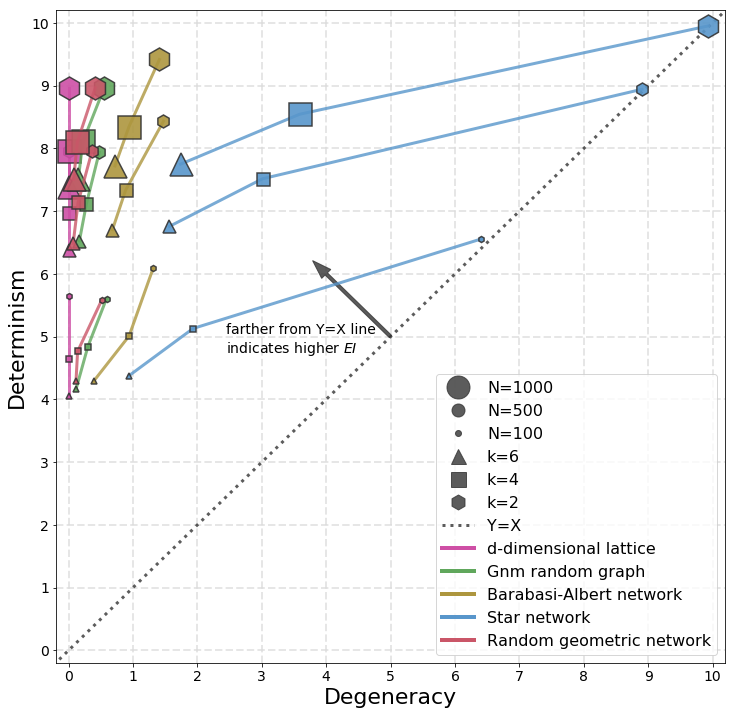

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[1000], color='#333333', label=r'N=1000', alpha=0.8)
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[500], color='#333333', label=r'N=500', alpha=0.8)
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[100], color='#333333', label=r'N=100', alpha=0.8)
ax.plot([100],[100], marker='^', linestyle='', markersize=15, color='#333333', label=r'k=6', alpha=0.8)
ax.plot([100],[100], marker='s', linestyle='', markersize=15, color='#333333', label=r'k=4', alpha=0.8)
ax.plot([100],[100], marker='h', linestyle='', markersize=15, color='#333333', label=r'k=2', alpha=0.8)
ax.plot([-0.5, 10.5], [-0.5, 10.5], marker='', linestyle=':', linewidth=3.0, color='#333333', label='Y=X', alpha=0.8)

for i in range(len(graph_names)):
    if i!=5 and i!=6 and i!=2:
        name = graph_names[i]
        n_edges = graph_dict[name]['E']
        n_nodes = graph_dict[name]['N']
        avg_deg = graph_dict[name]['k']
        degener = graph_dict[name]['degeneracy']
        determi = graph_dict[name]['determinism']
        eff_inf = graph_dict[name]['ei']
        cur = 0
        ax.plot(degener[0:3],   determi[0:3],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[3:6],   determi[3:6],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[6:9],   determi[6:9],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[9:12],  determi[9:12],  marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[12:15], determi[12:15], marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        for j in range(len(degener)):
            ma = deg_shape[avg_deg[j]]
            si = num_size[n_nodes[j]]
            ax.plot(degener[j],   determi[j],   marker=ma, linestyle='-', markersize=si, 
                    linewidth=2.0, color=cols[i], alpha=0.90, markeredgecolor='#333333', markeredgewidth=1.5)
        ax.plot([100],[100], marker='', linestyle='-', linewidth=4.0, color=cols[i], label=name)
    
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel("Determinism", size=22)
ax.set_xticks(np.arange(0,12,1))
ax.set_yticks(np.arange(0,12,1))
ax.set_xticklabels(np.arange(0,12,1), fontsize=14)
ax.set_yticklabels(np.arange(0,12,1), fontsize=14)
ax.set_xlim(-0.2, 10.2)
ax.set_ylim(-0.2, 10.2)

ax.arrow(5.0, 5.0, -1.0, 1.0, head_width=0.2, width=0.05, head_length=0.3, fc='#333333', ec='#333333', alpha=0.8)

ax.text(2.45, 5.05, "farther from Y=X line", fontsize=14)
ax.text(2.45, 4.75, r"indicates higher $EI$", fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(loc=4, fontsize=16, framealpha=0.8)
# plt.savefig("../figs/pngs/DetermDegen_ExampleNetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/DetermDegen_ExampleNetworks.pdf", bbox_inches='tight')
plt.show()

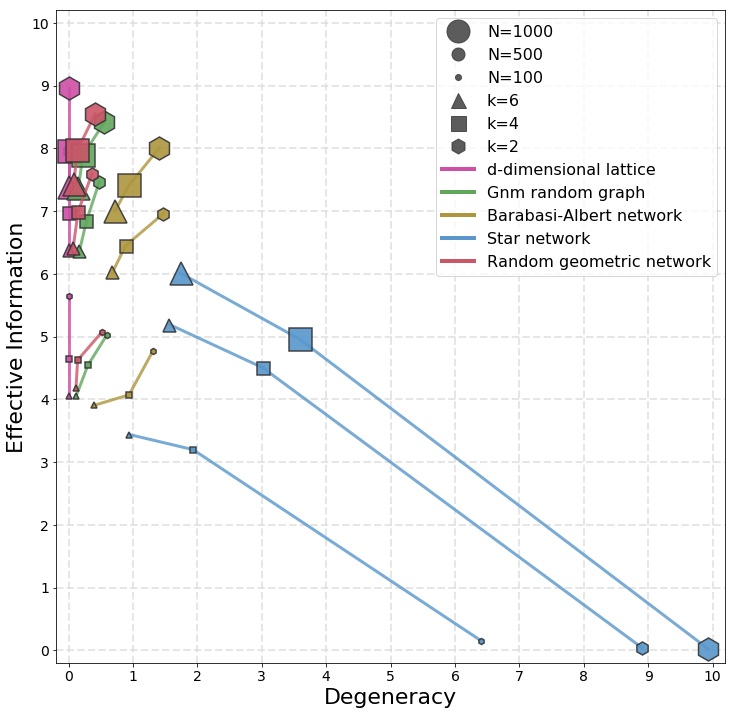

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[1000], color='#333333', label=r'N=1000', alpha=0.8)
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[500], color='#333333', label=r'N=500', alpha=0.8)
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[100], color='#333333', label=r'N=100', alpha=0.8)
ax.plot([100],[100], marker='^', linestyle='', markersize=15, color='#333333', label=r'k=6', alpha=0.8)
ax.plot([100],[100], marker='s', linestyle='', markersize=15, color='#333333', label=r'k=4', alpha=0.8)
ax.plot([100],[100], marker='h', linestyle='', markersize=15, color='#333333', label=r'k=2', alpha=0.8)

for i in range(len(graph_names)):
    if i!=5 and i!=6 and i!=2:
        name = graph_names[i]
        n_edges = graph_dict[name]['E']
        n_nodes = graph_dict[name]['N']
        avg_deg = graph_dict[name]['k']
        degener = graph_dict[name]['degeneracy']
        determi = graph_dict[name]['determinism']
        eff_inf = graph_dict[name]['ei']
        cur = 0
        ax.plot(degener[0:3],   eff_inf[0:3],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[3:6],   eff_inf[3:6],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[6:9],   eff_inf[6:9],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[9:12],  eff_inf[9:12],  marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(degener[12:15], eff_inf[12:15], marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        for j in range(len(degener)):
            ma = deg_shape[avg_deg[j]]
            si = num_size[n_nodes[j]]
            ax.plot(degener[j],   eff_inf[j],   marker=ma, linestyle='-', markersize=si, 
                    linewidth=2.0, color=cols[i], alpha=0.90, markeredgecolor='#333333', markeredgewidth=1.5)
        ax.plot([100],[100], marker='', linestyle='-', linewidth=4.0, color=cols[i], label=name)
    
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel("Effective Information", size=22)
ax.set_xticks(np.arange(0,12,1))
ax.set_yticks(np.arange(0,12,1))
ax.set_xticklabels(np.arange(0,12,1), fontsize=14)
ax.set_yticklabels(np.arange(0,12,1), fontsize=14)
ax.set_xlim(-0.2, 10.2)
ax.set_ylim(-0.2, 10.2)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=16, framealpha=0.8)

# plt.savefig("../figs/pngs/EffectiveInformation_Degen.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInformation_Degen.pdf", bbox_inches='tight')
plt.show()

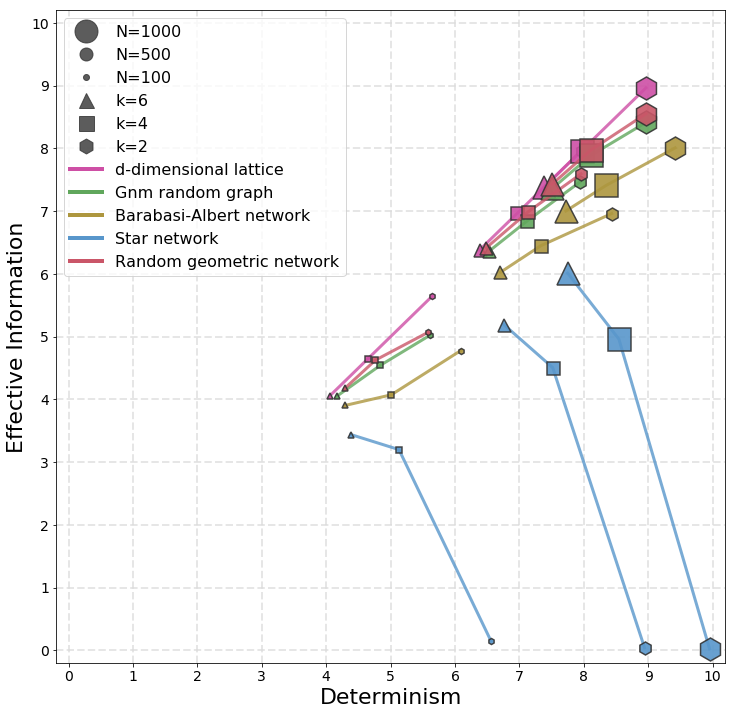

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[1000], color='#333333', label=r'N=1000', alpha=0.8)
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[500], color='#333333', label=r'N=500', alpha=0.8)
ax.plot([100],[100], marker='o', linestyle='', markersize=num_size[100], color='#333333', label=r'N=100', alpha=0.8)
ax.plot([100],[100], marker='^', linestyle='', markersize=15, color='#333333', label=r'k=6', alpha=0.8)
ax.plot([100],[100], marker='s', linestyle='', markersize=15, color='#333333', label=r'k=4', alpha=0.8)
ax.plot([100],[100], marker='h', linestyle='', markersize=15, color='#333333', label=r'k=2', alpha=0.8)

for i in range(len(graph_names)):
    if i!=5 and i!=6 and i!=2:
        name = graph_names[i]
        n_edges = graph_dict[name]['E']
        n_nodes = graph_dict[name]['N']
        avg_deg = graph_dict[name]['k']
        degener = graph_dict[name]['degeneracy']
        determi = graph_dict[name]['determinism']
        eff_inf = graph_dict[name]['ei']
        cur = 0
        ax.plot(determi[0:3],   eff_inf[0:3],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(determi[3:6],   eff_inf[3:6],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(determi[6:9],   eff_inf[6:9],   marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(determi[9:12],  eff_inf[9:12],  marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        ax.plot(determi[12:15], eff_inf[12:15], marker='', linestyle='-', 
                linewidth=3.0, color=cols[i], alpha=0.8)
        for j in range(len(degener)):
            ma = deg_shape[avg_deg[j]]
            si = num_size[n_nodes[j]]
            ax.plot(determi[j],   eff_inf[j],   marker=ma, linestyle='-', markersize=si, 
                    linewidth=2.0, color=cols[i], alpha=0.90, markeredgecolor='#333333', markeredgewidth=1.5)
        ax.plot([100],[100], marker='', linestyle='-', linewidth=4.0, color=cols[i], label=name)
    
ax.set_xlabel("Determinism", size=22)
ax.set_ylabel("Effective Information", size=22)
ax.set_xticks(np.arange(0,12,1))
ax.set_yticks(np.arange(0,12,1))
ax.set_xticklabels(np.arange(0,12,1), fontsize=14)
ax.set_yticklabels(np.arange(0,12,1), fontsize=14)
ax.set_xlim(-0.2, 10.2)
ax.set_ylim(-0.2, 10.2)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=16, framealpha=0.8)

# plt.savefig("../figs/pngs/EffectiveInformation_Determ.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInformation_Determ.pdf", bbox_inches='tight')
plt.show()

In [5]:
def weighted_directed_config_model(G):
    """
    INPUT
    -----
    G: a directed, weighted network
    
    OUTPUT
    ------
    H: randomized network with same strength distribution
       as the original network and the contribution to strength 
       of each node in terms of its in-weights and out-weights
       is the same
    """
    # Get the in- and out-degree distributions
    k_in = dict(G.in_degree())
    k_out = dict(G.out_degree())
    weights_in = dict(G.in_degree(weight='weight'))
    weights_out = dict(G.out_degree(weight='weight'))
    # Get stubs lists
    in_stubs = []
    out_stubs = []
    for node in weights_in:
        for _ in range(k_in[node]):
            in_stubs.append(node)
        for _ in range(k_out[node]):
            out_stubs.append(node)
    # Shuffle stubs lists
    np.random.shuffle(in_stubs)
    np.random.shuffle(out_stubs)
    # Make network by popping from each stub list
    H = nx.DiGraph()
    for _ in range(len(in_stubs)):
        source = out_stubs.pop()
        target = in_stubs.pop()
        if H.has_edge(source, target):
            H[source][target]['weight'] += 1
        else:
            H.add_edge(source, target, weight=1)
    
    
    
    return H

In [38]:
W = weighted_directed_config_model(Gba)

In [6]:
mouse1 = '../data/mouse_visual.cortex_1.graphml'
mouse2 = '../data/mouse_visual.cortex_2.graphml'
rat1 = '../data/rattus.norvegicus_brain_1.graphml'
rat2 = '../data/rattus.norvegicus_brain_2.graphml'
rat3 = '../data/rattus.norvegicus_brain_3.graphml'
power = '../data/power.gml'
words = '../data/word_adjacencies.gml'
protein = '../data/out.maayan-figeys.txt'
amazon = '../data/amazon.txt'
cora = '../data/cora.txt'
arXiv = '../data/arXiv.txt'
java = '../data/java.txt'
interact = '../data/species_interact.csv'
avogato = '../data/avogato.txt'
yeast_c = '../data/yeast_coulomb.txt'
yeast_y = '../data/yeast_y2h.txt'
darkweb = '../data/darkweb.txt'
requirements = '../data/requirements.csv'
humanprotein = '../data/humanprotein_steizl.txt'
usflights = '../data/flights_us.txt'
humanreactome = '../data/reactome.txt'
ara_cvi_1 = '../data/ara_cvi_1.csv'
ara_cvi_2 = '../data/ara_cvi_2.csv'
ara_cvi_3 = '../data/ara_cvi_3.csv'
ara_ler_1 = '../data/ara_ler_1.csv'
ara_ler_2 = '../data/ara_ler_2.csv'
ara_ler_3 = '../data/ara_ler_3.csv'
ara_col_1 = '../data/ara_col_1.csv'
ara_col_2 = '../data/ara_col_2.csv'
ara_col_3 = '../data/ara_col_3.csv'

In [10]:
G_mo1 = nx.read_graphml(mouse1)
G_mo2 = nx.read_graphml(mouse2)
G_ra1 = nx.read_graphml(rat1)
G_ra2 = nx.read_graphml(rat2)
G_ra3 = nx.read_graphml(rat3)
G_pow = nx.read_gml(power, label='id')
G_wor = nx.read_gml(words)
G_pro = nx.read_edgelist(protein, delimiter=" ")
G_ama = nx.read_edgelist(amazon, delimiter=" ")
G_cor = nx.read_edgelist(cora, delimiter=" ", create_using=nx.DiGraph())
G_arx = nx.read_edgelist(arXiv, delimiter=" ", create_using=nx.DiGraph())
G_jav = nx.read_edgelist(java, delimiter=" ", create_using=nx.DiGraph())
G_avo = nx.read_weighted_edgelist(avogato, delimiter=" ", create_using=nx.DiGraph())
G_int = nx.read_weighted_edgelist(interact, delimiter=",", create_using=nx.DiGraph())
G_yeC = nx.read_edgelist(yeast_c, delimiter=" ")
G_yeY = nx.read_edgelist(yeast_y, delimiter=" ")
G_dar = nx.read_weighted_edgelist(darkweb, delimiter=" ", create_using=nx.DiGraph())
# G_req = nx.read_edgelist(requirements, delimiter=",", create_using=nx.DiGraph())
G_hpi = nx.read_edgelist(humanprotein, delimiter=' ')
G_usf = nx.read_weighted_edgelist(usflights, delimiter=" ", create_using=nx.DiGraph())
G_hra = nx.read_edgelist(humanreactome, delimiter=' ')
G_cel = G_varshney.copy()

G_ar1 = nx.read_weighted_edgelist(ara_cvi_1, delimiter=',')
G_ar2 = nx.read_weighted_edgelist(ara_cvi_2, delimiter=',')
G_ar3 = nx.read_weighted_edgelist(ara_cvi_3, delimiter=',')
G_ar4 = nx.read_weighted_edgelist(ara_ler_1, delimiter=',')
G_ar5 = nx.read_weighted_edgelist(ara_ler_2, delimiter=',')
G_ar6 = nx.read_weighted_edgelist(ara_ler_3, delimiter=',')
G_ar7 = nx.read_weighted_edgelist(ara_col_1, delimiter=',')
G_ar8 = nx.read_weighted_edgelist(ara_col_2, delimiter=',')
G_ar9 = nx.read_weighted_edgelist(ara_col_3, delimiter=',')

In [206]:
graph_names = ['mouse_visual_1', 
               'mouse_visual_2', 
               'rat_brain_1', 
               'rat_brain_2', 
               'rat_brain_3', 
               'power_grid', 
               'word_adjacency',
               'human_ppi1', 
               'human_ppi2',
               'human_reactome',
               'amazon_purchaces',
               'cora_citations',
               'arXiv_citations',
               'java_dependencies',
               'avogato_trust', 
               'species_interactome', 
               'yeast_coulomb', 
#                'yeast_y2h', 
               'darkweb', 
               'us_flights',
               'c_elegans']#, 
#                'arabidopsis_capeverde1', 
#                'arabidopsis_capeverde2', 
#                'arabidopsis_capeverde3', 
#                'arabidopsis_landsberg1', 
#                'arabidopsis_landsberg2', 
#                'arabidopsis_landsberg3', 
#                'arabidopsis_colombia1', 
#                'arabidopsis_colombia2', 
#                'arabidopsis_colombia3']

m1 = {'determinism':get_determinism(G_mo1), 'degeneracy':get_degeneracy(G_mo1, p0=0), 
      'ei':get_ei(G_mo1, p0=0),'N':G_mo1.number_of_nodes(), 'E':G_mo1.number_of_edges(), 
      'G':nx.to_directed(G_mo1)}

m2 = {'determinism':get_determinism(G_mo2), 'degeneracy':get_degeneracy(G_mo2, p0=0), 
      'ei':get_ei(G_mo2, p0=0),'N':G_mo2.number_of_nodes(), 'E':G_mo2.number_of_edges(), 
      'G':nx.to_directed(G_mo2)}

r1 = {'determinism':get_determinism(G_ra1), 'degeneracy':get_degeneracy(G_ra1, p0=0), 
      'ei':get_ei(G_ra1, p0=0),'N':G_ra1.number_of_nodes(), 'E':G_ra1.number_of_edges(), 
      'G':nx.to_directed(G_ra1)}
r2 = {'determinism':get_determinism(G_ra2), 'degeneracy':get_degeneracy(G_ra2, p0=0), 
      'ei':get_ei(G_ra2, p0=0),'N':G_ra2.number_of_nodes(), 'E':G_ra2.number_of_edges(), 
      'G':nx.to_directed(G_ra2)}
r3 = {'determinism':get_determinism(G_ra3), 'degeneracy':get_degeneracy(G_ra3, p0=0), 
      'ei':get_ei(G_ra3, p0=0),'N':G_ra3.number_of_nodes(), 'E':G_ra3.number_of_edges(), 
      'G':nx.to_directed(G_ra3)}

po = {'determinism':get_determinism(G_pow), 'degeneracy':get_degeneracy(G_pow, p0=0), 
      'ei':get_ei(G_pow, p0=0),'N':G_pow.number_of_nodes(), 'E':G_pow.number_of_edges(), 
      'G':nx.to_directed(G_pow)}

wo = {'determinism':get_determinism(G_wor), 'degeneracy':get_degeneracy(G_wor, p0=0), 
      'ei':get_ei(G_wor, p0=0),'N':G_wor.number_of_nodes(), 'E':G_wor.number_of_edges(), 
      'G':nx.to_directed(G_wor)}

pr = {'determinism':get_determinism(G_pro), 'degeneracy':get_degeneracy(G_pro, p0=0), 
      'ei':get_ei(G_pro, p0=0),'N':G_pro.number_of_nodes(), 'E':G_pro.number_of_edges(), 
      'G':nx.to_directed(G_pro)}

am = {'determinism':get_determinism(G_ama), 'degeneracy':get_degeneracy(G_ama, p0=0), 
      'ei':get_ei(G_ama, p0=0),'N':G_ama.number_of_nodes(), 'E':G_ama.number_of_edges(), 
      'G':nx.to_directed(G_ama)}

co = {'determinism':get_determinism(G_cor), 'degeneracy':get_degeneracy(G_cor, p0=0), 
      'ei':get_ei(G_cor, p0=0),'N':G_cor.number_of_nodes(), 'E':G_cor.number_of_edges(), 
      'G':nx.to_directed(G_cor)}

ar = {'determinism':get_determinism(G_arx), 'degeneracy':get_degeneracy(G_arx, p0=0), 
      'ei':get_ei(G_arx, p0=0),'N':G_arx.number_of_nodes(), 'E':G_arx.number_of_edges(), 
      'G':nx.to_directed(G_arx)}

ja = {'determinism':get_determinism(G_jav), 'degeneracy':get_degeneracy(G_jav, p0=0), 
      'ei':get_ei(G_jav, p0=0),'N':G_jav.number_of_nodes(), 'E':G_jav.number_of_edges(), 
      'G':nx.to_directed(G_jav)}

av = {'determinism':get_determinism(G_avo), 'degeneracy':get_degeneracy(G_avo, p0=0), 
      'ei':get_ei(G_avo, p0=0),'N':G_avo.number_of_nodes(), 'E':G_avo.number_of_edges(), 
      'G':nx.to_directed(G_avo)}

nt = {'determinism':get_determinism(G_int), 'degeneracy':get_degeneracy(G_int, p0=0), 
      'ei':get_ei(G_int, p0=0),'N':G_int.number_of_nodes(), 'E':G_int.number_of_edges(), 
      'G':nx.to_directed(G_int)}

yC = {'determinism':get_determinism(G_yeC), 'degeneracy':get_degeneracy(G_yeC, p0=0), 
      'ei':get_ei(G_yeC, p0=0),'N':G_yeC.number_of_nodes(), 'E':G_yeC.number_of_edges(), 
      'G':nx.to_directed(G_yeC)}

# yY = {'determinism':get_determinism(G_yeY), 'degeneracy':get_degeneracy(G_yeY, p0=0), 
#       'ei':get_ei(G_yeY, p0=0),'N':G_yeY.number_of_nodes(), 'E':G_yeY.number_of_edges(), 
#       'G':nx.to_directed(G_yeY)}

dw = {'determinism':get_determinism(G_dar), 'degeneracy':get_degeneracy(G_dar, p0=0), 
      'ei':get_ei(G_dar, p0=0),'N':G_dar.number_of_nodes(), 'E':G_dar.number_of_edges(), 
      'G':nx.to_directed(G_dar)}

hp = {'determinism':get_determinism(G_hpi), 'degeneracy':get_degeneracy(G_hpi, p0=0), 
      'ei':get_ei(G_hpi, p0=0),'N':G_hpi.number_of_nodes(), 'E':G_hpi.number_of_edges(), 
      'G':nx.to_directed(G_hpi)}

fl = {'determinism':get_determinism(G_usf), 'degeneracy':get_degeneracy(G_usf, p0=0), 
      'ei':get_ei(G_usf, p0=0),'N':G_usf.number_of_nodes(), 'E':G_usf.number_of_edges(), 
      'G':nx.to_directed(G_usf)}

re = {'determinism':get_determinism(G_hra), 'degeneracy':get_degeneracy(G_hra, p0=0), 
      'ei':get_ei(G_hra, p0=0),'N':G_hra.number_of_nodes(), 'E':G_hra.number_of_edges(), 
      'G':nx.to_directed(G_hra)}

ce = {'determinism':get_determinism(G_cel), 'degeneracy':get_degeneracy(G_cel, p0=0), 
      'ei':get_ei(G_cel, p0=0),'N':G_cel.number_of_nodes(), 'E':G_cel.number_of_edges(), 
      'G':nx.to_directed(G_cel)}

# a1 = {'determinism':get_determinism(G_ar1), 'degeneracy':get_degeneracy(G_ar1, p0=0), 
#       'ei':get_ei(G_ar1, p0=0),'N':G_ar1.number_of_nodes(), 'E':G_ar1.number_of_edges(), 
#       'G':nx.to_directed(G_ar1)}

# a2 = {'determinism':get_determinism(G_ar2), 'degeneracy':get_degeneracy(G_ar2, p0=0), 
#       'ei':get_ei(G_ar2, p0=0),'N':G_ar2.number_of_nodes(), 'E':G_ar2.number_of_edges(), 
#       'G':nx.to_directed(G_ar2)}

# a3 = {'determinism':get_determinism(G_ar3), 'degeneracy':get_degeneracy(G_ar3, p0=0), 
#       'ei':get_ei(G_ar3, p0=0),'N':G_ar3.number_of_nodes(), 'E':G_ar3.number_of_edges(), 
#       'G':nx.to_directed(G_ar3)}

# a4 = {'determinism':get_determinism(G_ar4), 'degeneracy':get_degeneracy(G_ar4, p0=0), 
#       'ei':get_ei(G_ar4, p0=0),'N':G_ar4.number_of_nodes(), 'E':G_ar4.number_of_edges(), 
#       'G':nx.to_directed(G_ar4)}

# a5 = {'determinism':get_determinism(G_ar5), 'degeneracy':get_degeneracy(G_ar5, p0=0), 
#       'ei':get_ei(G_ar5, p0=0),'N':G_ar5.number_of_nodes(), 'E':G_ar5.number_of_edges(), 
#       'G':nx.to_directed(G_ar5)}

# a6 = {'determinism':get_determinism(G_ar6), 'degeneracy':get_degeneracy(G_ar6, p0=0), 
#       'ei':get_ei(G_ar6, p0=0),'N':G_ar6.number_of_nodes(), 'E':G_ar6.number_of_edges(), 
#       'G':nx.to_directed(G_ar6)}

# a7 = {'determinism':get_determinism(G_ar7), 'degeneracy':get_degeneracy(G_ar7, p0=0), 
#       'ei':get_ei(G_ar7, p0=0),'N':G_ar7.number_of_nodes(), 'E':G_ar7.number_of_edges(), 
#       'G':nx.to_directed(G_ar7)}

# a8 = {'determinism':get_determinism(G_ar8), 'degeneracy':get_degeneracy(G_ar8, p0=0), 
#       'ei':get_ei(G_ar8, p0=0),'N':G_ar8.number_of_nodes(), 'E':G_ar8.number_of_edges(), 
#       'G':nx.to_directed(G_ar8)}

# a9 = {'determinism':get_determinism(G_ar9), 'degeneracy':get_degeneracy(G_ar9, p0=0), 
#       'ei':get_ei(G_ar9, p0=0),'N':G_ar9.number_of_nodes(), 'E':G_ar9.number_of_edges(), 
#       'G':nx.to_directed(G_ar9)}

# list_of_graphdicts = [m1, m2, r1, r2, r3, po, wo, pr, hp, re, am, co, ar, ja, av, nt, yC, dw, fl, ce]#, 
#                       a1, a2, a3, a4, a5, a6, a7, a8, a9]

# list_of_graphdicts = [m1, m2, r1, r2, r3, po, wo, pr, hp, re, am, co, ja, av, nt, yC, dw, fl, ce, 
#                       a1, a2, a3, a4, a5, a6, a7, a8, a9]

# list_of_graphdicts = [m1, m2, r1, r2, r3, po, wo, pr, am, co, ar, ja, av, nt, yC, yY, dw, hp, fl, re, ce, 
#                       a1, a2, a3, a4, a5, a6, a7, a8, a9]

In [220]:
cols = ["#ce6a3d", "#b5292f", "#4d71af", "#4e77e0", "#63a7de", "#502f4c", "#9453b2", "#ff7a33", '#ff5371', 
        "#ef86d0", "#ab3a00", "#02b2ed", '#016096', "#a791ff", "#abaf71", "#5f1e6b", "#ce7700", "#440aac", "#456800",
        "#f49073", "#564c36", "#fff3db", "#210f00", "#9f8975", "#1a1814", "#9d8389", "#4b2d32", "#726669", "#73584b"]

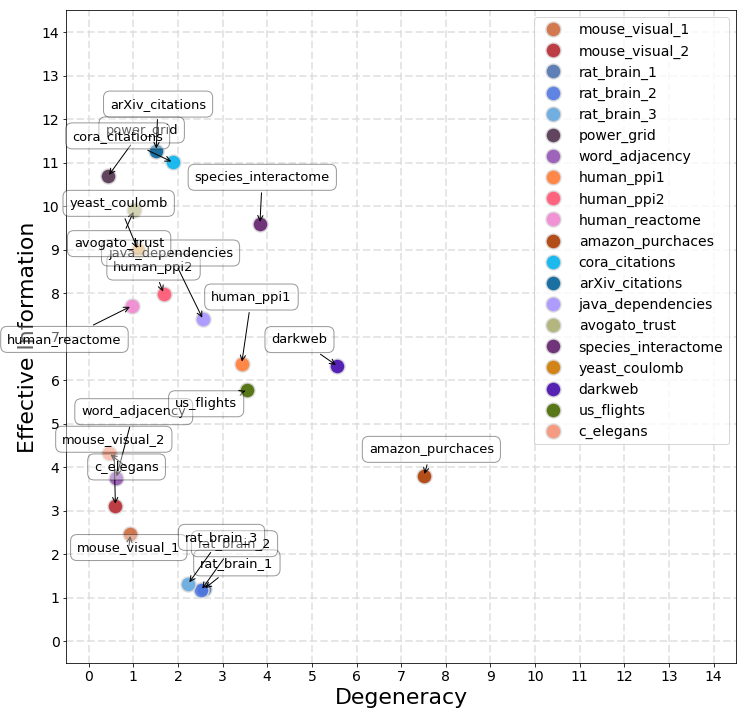

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    ax.plot([degener],   [eff_inf],   marker=ma, linestyle='', markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    move_x = np.random.choice([-10,30,50,70])
    move_y = np.random.choice([-40,-20,20,40,60])
    ax.annotate(name, xy=(degener, eff_inf), ha='right', va='bottom', xytext=(move_x, move_y), fontsize=13,
                textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel("Effective Information", size=22)
ax.set_xticks(np.arange(0,15,1))
ax.set_yticks(np.arange(0,15,1))
ax.set_xticklabels(np.arange(0,15,1), fontsize=14)
ax.set_yticklabels(np.arange(0,15,1), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.5, 14.5)
ax.set_ylim(-0.5, 14.5)

# plt.savefig("../figs/pngs/EffectiveInformation_Degen_30realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInformation_Degen_30realnetworks.pdf", bbox_inches='tight')
plt.show()

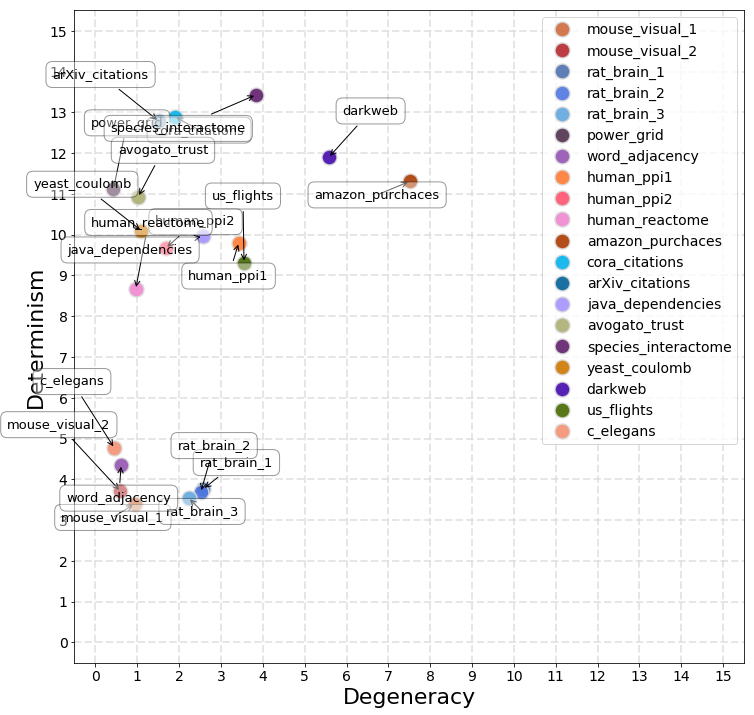

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    ax.plot([degener],   [determi],   marker=ma, linestyle='', markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    move_x = np.random.choice([-10,30,50,70])
    move_y = np.random.choice([-40,-20,20,40,60])
    ax.annotate(name, xy=(degener, determi), ha='right', va='bottom', xytext=(move_x, move_y), fontsize=13,
                textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel("Determinism", size=22)
ax.set_xticks(np.arange(0,16,1))
ax.set_yticks(np.arange(0,16,1))
ax.set_xticklabels(np.arange(0,16,1), fontsize=14)
ax.set_yticklabels(np.arange(0,16,1), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.5, 15.5)
ax.set_ylim(-0.5, 15.5)

# plt.savefig("../figs/pngs/Determ_Degen_30realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Determ_Degen_30realnetworks.pdf", bbox_inches='tight')
plt.show()

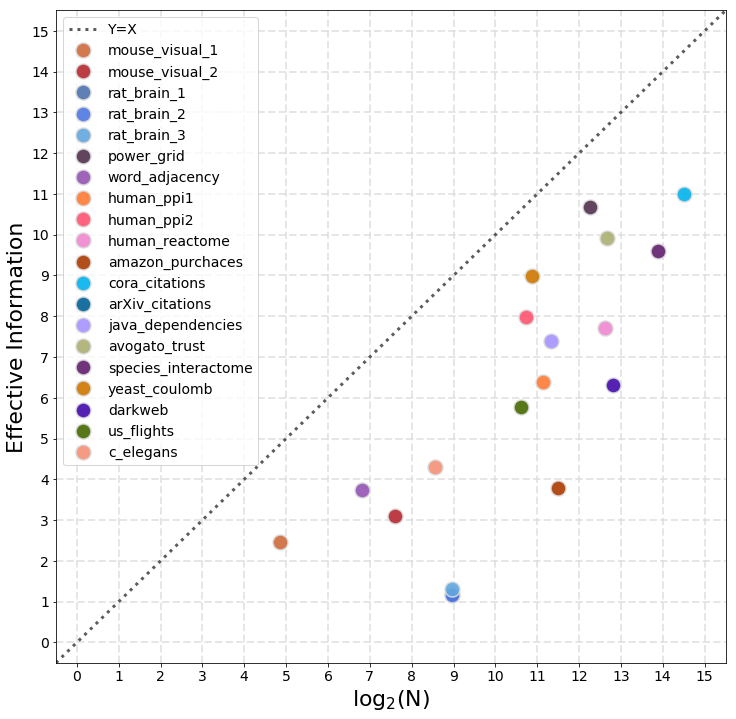

In [293]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 15.5], [-0.5, 15.5], marker='', linestyle=':', linewidth=3.0, color='#333333', label='Y=X', alpha=0.8)

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    ax.plot([np.log2(n_nodes)],   [eff_inf],   marker=ma, linestyle='', markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
#     move_x = np.random.choice([-10,30,50,70])
#     move_y = np.random.choice([-40,-20,20,40,60])
#     ax.annotate(name, xy=(np.log2(n_nodes), eff_inf), ha='right', va='bottom', 
#                 xytext=(move_x, move_y), fontsize=13,
#                 textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
#                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.set_xlabel(r"log$_2$(N)", size=22)
ax.set_ylabel("Effective Information", size=22)
ax.set_xticks(np.arange(0,16,1))
ax.set_yticks(np.arange(0,16,1))
ax.set_xticklabels(np.arange(0,16,1), fontsize=14)
ax.set_yticklabels(np.arange(0,16,1), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.5, 15.5)
ax.set_ylim(-0.5, 15.5)

# plt.savefig("../figs/pngs/EffectiveInformation_logN_30realnetworks1.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInformation_logN_30realnetworks1.pdf", bbox_inches='tight')
plt.show()

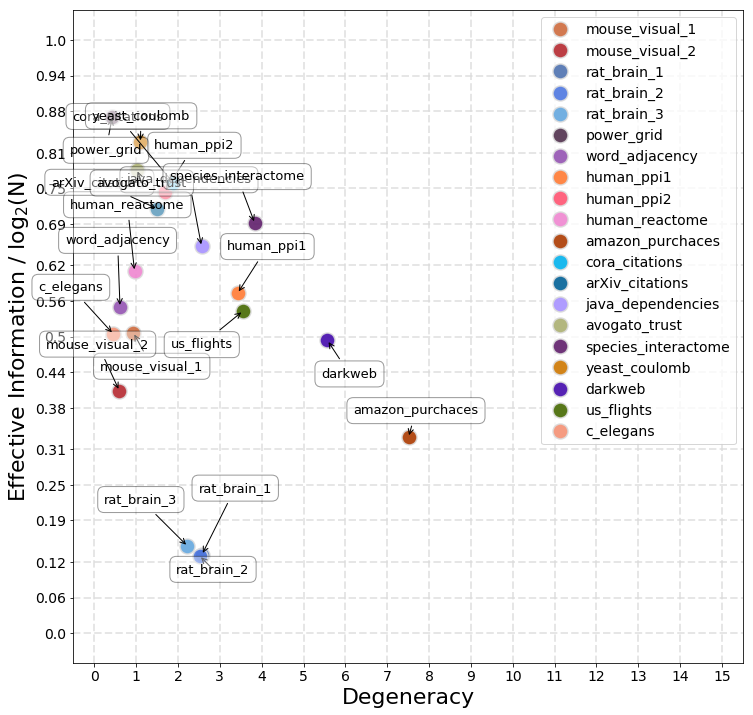

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    ax.plot([degener],   [eff_inf/np.log2(n_nodes)],   marker=ma, linestyle='',
            markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    move_x = np.random.choice([-10,30,50,70])
    move_y = np.random.choice([-40,-20,20,40,60])
    ax.annotate(name, xy=(degener, eff_inf/np.log2(n_nodes)), ha='right', va='bottom', 
                xytext=(move_x, move_y), fontsize=13,
                textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel(r"Effective Information / log$_2$(N)", size=22)
ax.set_xticks(np.arange(0,16,1))
ax.set_yticks(np.round(np.linspace(0,1.0,17), 2))
ax.set_xticklabels(np.arange(0,16,1), fontsize=14)
ax.set_yticklabels(np.round(np.linspace(0,1.0,17), 2), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.5, 15.5)
ax.set_ylim(-0.05, 1.05)

# plt.savefig("../figs/pngs/norm_EffectiveInformation_degen_30realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/norm_EffectiveInformation_degen_30realnetworks.pdf", bbox_inches='tight')
plt.show()

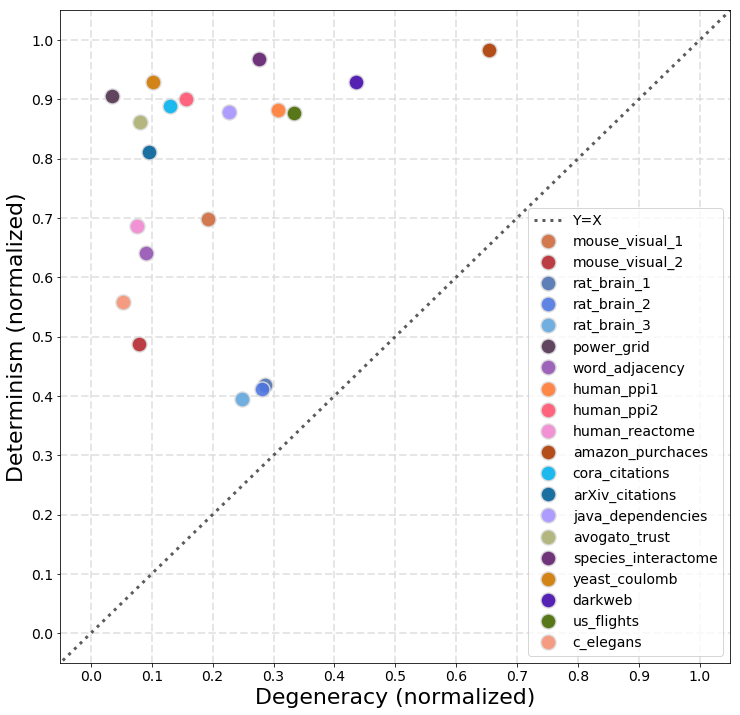

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
plt.plot([-0.5, 10.5], [-0.5, 10.5], marker='', linestyle=':', linewidth=3.0, color='#333333', label='Y=X', alpha=0.8)

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    ax.plot([degener/np.log2(n_nodes)],   [determi/np.log2(n_nodes)],   marker=ma, linestyle='',
            markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
#     move_x = np.random.choice([10,30,50,70])
#     move_y = np.random.choice([-40,-20,20,40])
#     ax.annotate(name, xy=(degener/np.log2(n_nodes), determi/np.log2(n_nodes)), 
#                 ha='right', va='bottom', xytext=(move_x, move_y), fontsize=13,
#                 textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
#                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.set_xlabel("Degeneracy (normalized)", size=22)
ax.set_ylabel("Determinism (normalized)", size=22)
ax.set_xticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_yticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_xticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=14)
ax.set_yticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# plt.savefig("../figs/pngs/normDeterm_normDegen_30realnetworks1.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/normDeterm_normDegen_30realnetworks1.pdf", bbox_inches='tight')
plt.show()

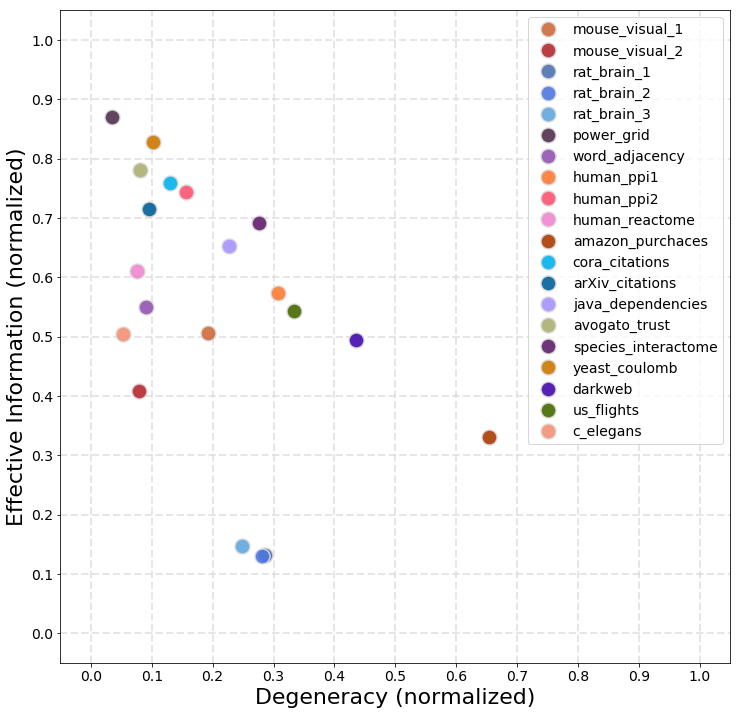

In [289]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    ax.plot([degener/np.log2(n_nodes)],   [eff_inf/np.log2(n_nodes)],   marker=ma, linestyle='',
            markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
#     move_x = np.random.choice([10,30,50,70])
#     move_y = np.random.choice([-40,-20,20,40])
#     ax.annotate(name, xy=(degener/np.log2(n_nodes), eff_inf/np.log2(n_nodes)), ha='right', va='bottom', xytext=(move_x, move_y), fontsize=13,
#                 textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
#                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.set_xlabel("Degeneracy (normalized)", size=22)
ax.set_ylabel("Effective Information (normalized)", size=22)
ax.set_xticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_yticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_xticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=14)
ax.set_yticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# plt.savefig("../figs/pngs/normEffectiveInfo_normDegen_30realnetworks1.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/normEffectiveInfo_normDegen_30realnetworks1.pdf", bbox_inches='tight')
plt.show()

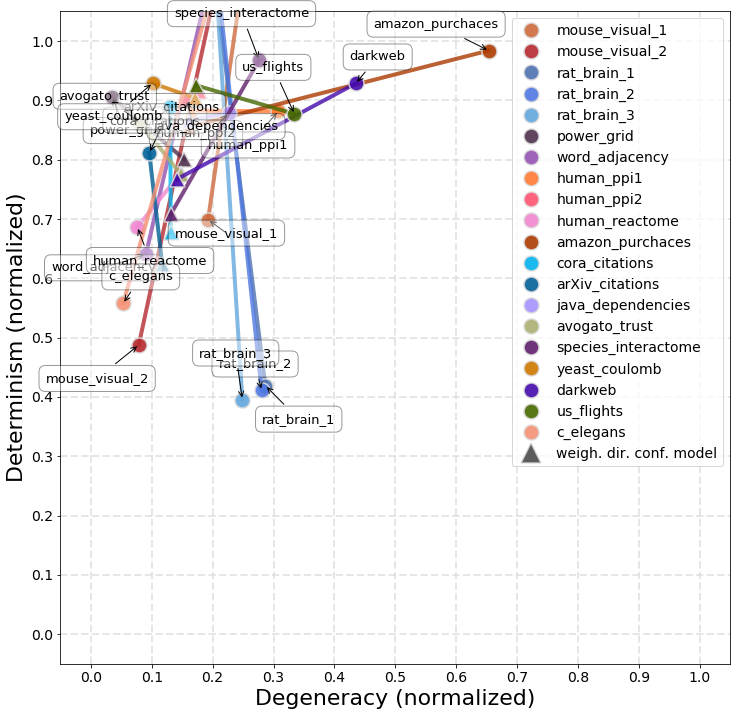

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 15
    conf_Gr = weighted_directed_config_model(curr_Gr)
    conf_degen = get_degeneracy(conf_Gr, p0=0)
    conf_deter = get_determinism(conf_Gr, p0=0)
    conf_ei = get_ei(conf_Gr, p0=0)    
    
    ax.plot([degener/np.log2(n_nodes), conf_degen/np.log2(n_nodes)], 
            [determi/np.log2(n_nodes), conf_deter/np.log2(n_nodes)], marker='', linestyle='-',  
            linewidth=4.0, color=cols[i], alpha=0.80)
    ax.plot([degener/np.log2(n_nodes)],   [determi/np.log2(n_nodes)],   marker=ma, linestyle='',
            markersize=si, label=name, color=cols[i], 
            alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    ax.plot([conf_degen/np.log2(n_nodes)], [conf_deter/np.log2(n_nodes)], marker='^', linestyle='', markersize=si, 
            color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    
    move_x = np.random.choice([10,30,50,70])
    move_y = np.random.choice([-40,-20,20,40])
    ax.annotate(name, xy=(degener/np.log2(n_nodes), determi/np.log2(n_nodes)), ha='right', va='bottom', xytext=(move_x, move_y), fontsize=13,
                textcoords='offset points',bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.4),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
ax.plot([100],[100], marker='^', linestyle='', markersize=20, color='#333333', 
        markeredgecolor='gainsboro', markeredgewidth=1.5, label='weigh. dir. conf. model', alpha=0.8)
    
ax.set_xlabel("Degeneracy (normalized)", size=22)
ax.set_ylabel("Determinism (normalized)", size=22)
ax.set_xticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_yticks(np.round(np.linspace(0,1.0,11), 2))
ax.set_xticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=14)
ax.set_yticklabels(np.round(np.linspace(0,1.0,11), 2), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=14, framealpha=0.8)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# plt.savefig("../figs/pngs/normDeterm_normDegen_30realnetworks_c.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/normDeterm_normDegen_30realnetworks_c.pdf", bbox_inches='tight')
plt.show()

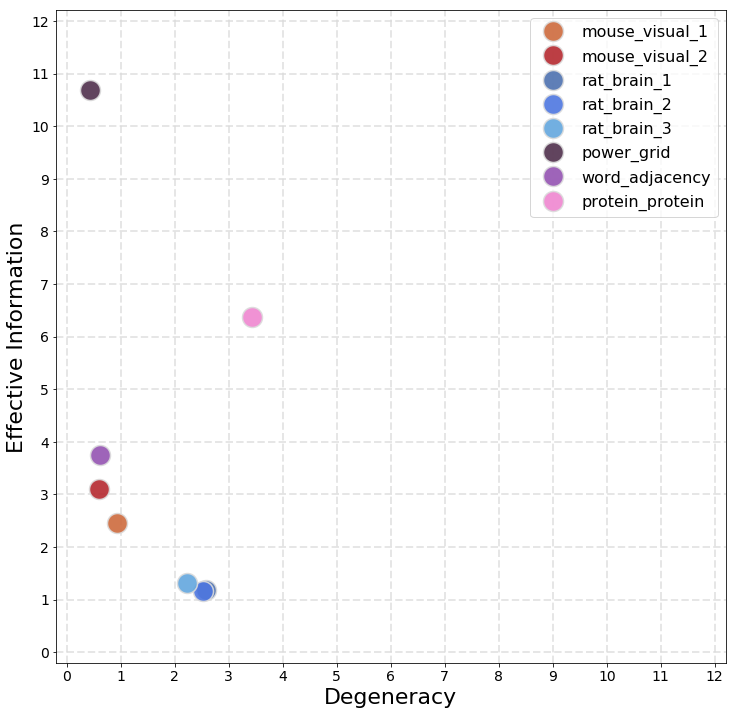

In [59]:
# fig, ax = plt.subplots(1, 1, figsize=(12,12))

# for i in range(len(graph_names)):
#     G_info = list_of_graphdicts[i]
#     name = graph_names[i]
#     n_edges = G_info['E']
#     n_nodes = G_info['N']
# #     avg_deg = G_info['k']
#     degener = G_info['degeneracy']
#     determi = G_info['determinism']
#     eff_inf = G_info['ei']
#     cur = 0
#     ma = 'o'
#     si = 20
#     ax.plot([degener],   [eff_inf],   marker=ma, linestyle='', markersize=si, label=name, 
#             color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    
# ax.set_xlabel("Degeneracy", size=22)
# ax.set_ylabel("Effective Information", size=22)
# ax.set_xticks(np.arange(0,13,1))
# ax.set_yticks(np.arange(0,13,1))
# ax.set_xticklabels(np.arange(0,13,1), fontsize=14)
# ax.set_yticklabels(np.arange(0,13,1), fontsize=14)

# ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
# ax.set_axisbelow(1)

# ax.legend(fontsize=16, framealpha=0.8)
# ax.set_xlim(-0.2, 12.2)
# ax.set_ylim(-0.2, 12.2)

# plt.savefig("../figs/pngs/EffectiveInformation_Degen_realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInformation_Degen_realnetworks.pdf", bbox_inches='tight')
# plt.show()

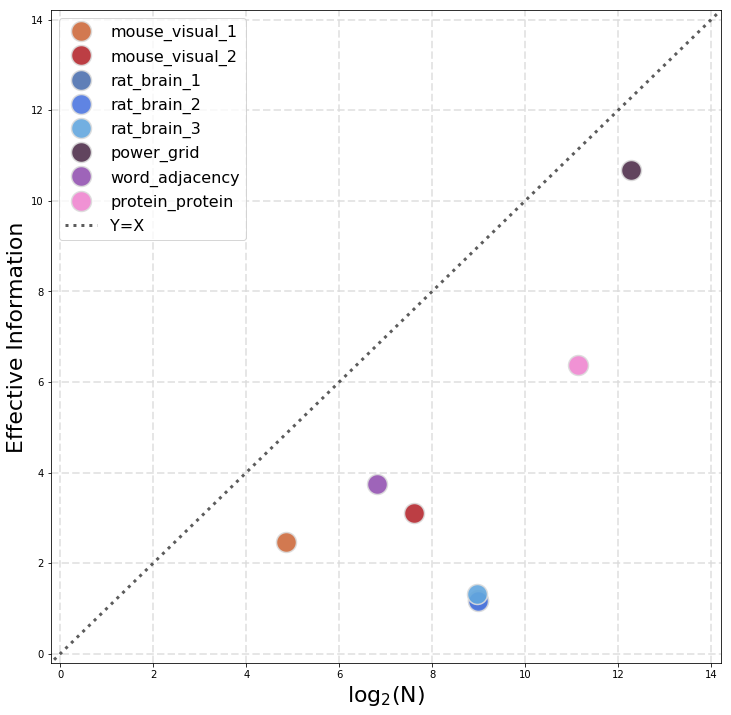

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
#     avg_deg = G_info['k']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    cur = 0
    ma = 'o'
    si = 20
    ax.plot([np.log2(n_nodes)],   [eff_inf],   marker=ma, linestyle='', markersize=si, label=name, 
            color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    
ax.plot([-0.5, 15.5], [-0.5, 15.5], marker='', linestyle=':', linewidth=3.0, color='#333333', label='Y=X', alpha=0.8)
ax.set_xlabel(r"log$_2$(N)", size=22)
ax.set_ylabel("Effective Information", size=22)
# ax.set_xticks(np.arange(0,13,1))
# ax.set_yticks(np.arange(0,13,1))
# ax.set_xticklabels(np.arange(0,13,1), fontsize=14)
# ax.set_yticklabels(np.arange(0,13,1), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)

ax.legend(fontsize=16, framealpha=0.8)
ax.set_xlim(-0.2, 14.2)
ax.set_ylim(-0.2, 14.2)

# plt.savefig("../figs/pngs/EffectiveInformation_N_realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInformation_N_realnetworks.pdf", bbox_inches='tight')
plt.show()

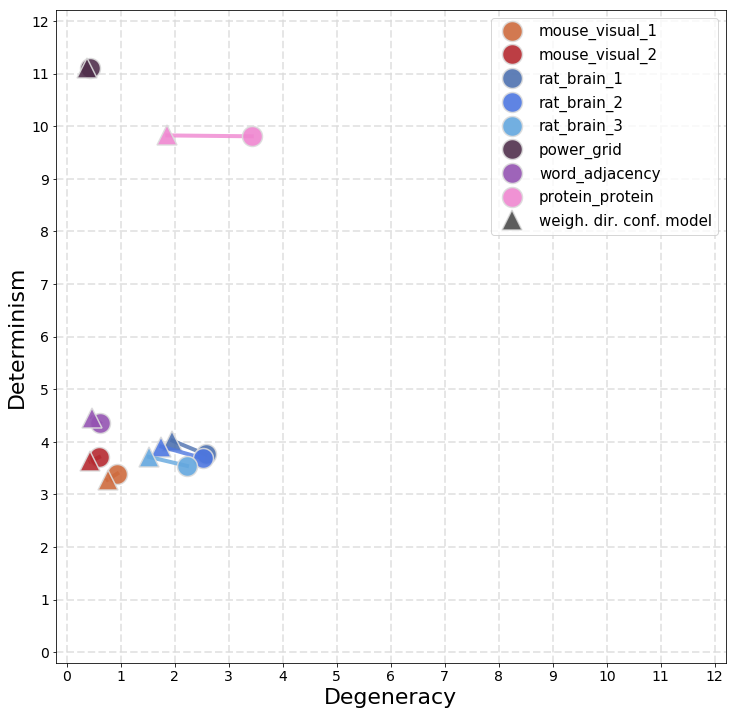

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    curr_Gr = G_info['G']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    
    conf_Gr = weighted_directed_config_model(curr_Gr)
#     din=list(dict(curr_Gr.in_degree()).values())
#     dout=list(dict(curr_Gr.out_degree()).values())
#     conf_Gr = nx.directed_configuration_model(din, dout)
    conf_degen = get_degeneracy(conf_Gr, p0=0)
    conf_deter = get_determinism(conf_Gr, p0=0)
    conf_ei = get_ei(conf_Gr, p0=0)
    
    ma = 'o'
    si = 20
    ax.plot([degener, conf_degen], [determi, conf_deter], marker='', linestyle='-',  
            linewidth=4.0, color=cols[i], alpha=0.80)
    ax.plot([degener], [determi], marker=ma, linestyle='', markersize=si, label=name, 
            color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    ax.plot([conf_degen], [conf_deter], marker='^', linestyle='', markersize=si, 
            color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)

    
ax.plot([100],[100], marker='^', linestyle='', markersize=20, color='#333333', 
        markeredgecolor='gainsboro', markeredgewidth=1.5, label='weigh. dir. conf. model', alpha=0.8)
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel("Determinism", size=22)
ax.set_xticks(np.arange(0,13,1))
ax.set_yticks(np.arange(0,13,1))
ax.set_xticklabels(np.arange(0,13,1), fontsize=14)
ax.set_yticklabels(np.arange(0,13,1), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)
ax.set_xlim(-0.2, 12.2)
ax.set_ylim(-0.2, 12.2)

ax.legend(fontsize=15, framealpha=0.8)

# plt.savefig("../figs/pngs/Determ_Degen_realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Determ_Degen_realnetworks.pdf", bbox_inches='tight')
plt.show()

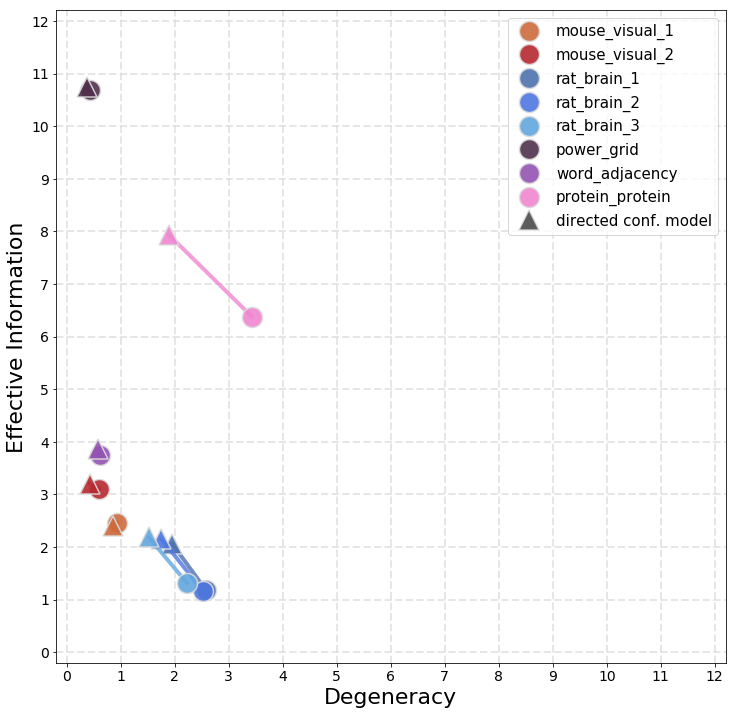

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))

for i in range(len(graph_names)):
    G_info = list_of_graphdicts[i]
    name = graph_names[i]
    n_edges = G_info['E']
    n_nodes = G_info['N']
    curr_Gr = G_info['G']
    degener = G_info['degeneracy']
    determi = G_info['determinism']
    eff_inf = G_info['ei']
    
    conf_Gr = weighted_directed_config_model(curr_Gr)
#     din=list(dict(curr_Gr.in_degree()).values())
#     dout=list(dict(curr_Gr.out_degree()).values())
#     conf_Gr = nx.directed_configuration_model(din, dout)
    conf_degen = get_degeneracy(conf_Gr, p0=0)
    conf_deter = get_determinism(conf_Gr, p0=0)
    conf_ei = get_ei(conf_Gr, p0=0)
    
    ma = 'o'
    si = 20
    ax.plot([degener, conf_degen], [eff_inf, conf_ei], marker='', linestyle='-',  
            linewidth=4.0, color=cols[i], alpha=0.80)
    ax.plot([degener], [eff_inf], marker=ma, linestyle='', markersize=si, label=name, 
            color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)
    ax.plot([conf_degen], [conf_ei], marker='^', linestyle='', markersize=si, 
            color=cols[i], alpha=0.90, markeredgecolor='gainsboro', markeredgewidth=1.5)

    
ax.plot([100],[100], marker='^', linestyle='', markersize=20, color='#333333', 
        markeredgecolor='gainsboro', markeredgewidth=1.5, label='directed conf. model', alpha=0.8)
ax.set_xlabel("Degeneracy", size=22)
ax.set_ylabel("Effective Information", size=22)
ax.set_xticks(np.arange(0,13,1))
ax.set_yticks(np.arange(0,13,1))
ax.set_xticklabels(np.arange(0,13,1), fontsize=14)
ax.set_yticklabels(np.arange(0,13,1), fontsize=14)

ax.grid(linestyle='--', color='gainsboro', linewidth=2.0, alpha=0.7)
ax.set_axisbelow(1)
ax.set_xlim(-0.2, 12.2)
ax.set_ylim(-0.2, 12.2)

ax.legend(fontsize=15, framealpha=0.8)

# plt.savefig("../figs/pngs/EffectiveInfo_Degen_realnetworks.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/EffectiveInfo_Degen_realnetworks.pdf", bbox_inches='tight')
plt.show()

_______________________________

In [281]:
d_away = 2
G_ra1 = nx.convert_node_labels_to_integers(G_ra1)
G_ra2 = nx.convert_node_labels_to_integers(G_ra2)
G_ra3 = nx.convert_node_labels_to_integers(G_ra3)

nodepairs_d2_r1 = get_paths(G_ra1, d=d_away)
nodepairs_d2_r2 = get_paths(G_ra2, d=d_away)
nodepairs_d2_r3 = get_paths(G_ra3, d=d_away)

print("In Rat1, the density is:", np.round(nx.density(G_ra1), 5))
print("In Rat2, the density is:", np.round(nx.density(G_ra2), 5))
print("In Rat3, the density is:", np.round(nx.density(G_ra3), 5))
print()
print("In Rat1, there are", len(nodepairs_d2_r1), "pairs of nodes at d =",d_away,"from one another.")
print("In Rat2, there are", len(nodepairs_d2_r2), "pairs of nodes at d =",d_away,"from one another.")
print("In Rat3, there are", len(nodepairs_d2_r3), "pairs of nodes at d =",d_away,"from one another.")
print()
# Let's try to macronode nodes in these networks 100 times.
n_steps = 10
n_edges_sampled = 100
G_macro_r1 = G_ra1.copy()
G_macro_r2 = G_ra2.copy()
G_macro_r3 = G_ra3.copy()

print("Rat1 starts with N =", G_macro_r1.number_of_nodes(), 
      "nodes and EI =", np.round(get_ei(G_macro_r1, p0=0.0),5))
print("Rat2 starts with N =", G_macro_r2.number_of_nodes(), 
      "nodes and EI =", np.round(get_ei(G_macro_r2, p0=0.0),5))
print("Rat3 starts with N =", G_macro_r3.number_of_nodes(), 
      "nodes and EI =", np.round(get_ei(G_macro_r3, p0=0.0),5))

In Rat1, the density is: 0.10957
In Rat2, the density is: 0.11916
In Rat3, the density is: 0.13449

In Rat1, there are 250712 pairs of nodes at d = 2 from one another.
In Rat2, there are 250311 pairs of nodes at d = 2 from one another.
In Rat3, there are 240863 pairs of nodes at d = 2 from one another.

Rat1 starts with N = 503 nodes and EI = 1.18829
Rat2 starts with N = 503 nodes and EI = 1.16952
Rat3 starts with N = 496 nodes and EI = 1.31519


In [282]:
macronodes_r1 = {}
macronodes_r2 = {}
macronodes_r3 = {}

print("Starting to span the possible groupings at:", datetime.datetime.now())
for i in range(n_steps):
    index_to_check_1 = np.random.choice(range(len(nodepairs_d2_r1)), size=n_edges_sampled)
    edges_to_check_1 = np.array(nodepairs_d2_r1)[index_to_check_1]
    edges_to_check_1 = [tuple(edges_to_check_1[i]) for i in range(len(edges_to_check_1))]
    
    index_to_check_2 = np.random.choice(range(len(nodepairs_d2_r2)), size=n_edges_sampled)
    edges_to_check_2 = np.array(nodepairs_d2_r2)[index_to_check_2]
    edges_to_check_2 = [tuple(edges_to_check_2[i]) for i in range(len(edges_to_check_2))]
    
    index_to_check_3 = np.random.choice(range(len(nodepairs_d2_r3)), size=n_edges_sampled)
    edges_to_check_3 = np.array(nodepairs_d2_r3)[index_to_check_3]
    edges_to_check_3 = [tuple(edges_to_check_3[i]) for i in range(len(edges_to_check_3))]
    
    ei_diff_dict_1, success_edges_1 = get_ei_diff(G_macro_r1, edges_to_check_1)
    ei_diff_dict_2, success_edges_2 = get_ei_diff(G_macro_r2, edges_to_check_2)
    ei_diff_dict_3, success_edges_3 = get_ei_diff(G_macro_r3, edges_to_check_3)
    
    if success_edges_1: 
        macro_edge_1 = sorted(ei_diff_dict_1.items(), key=operator.itemgetter(1))#[0][0]
        for eij in macro_edge_1:
            if eij[0] not in list(macronodes_r1.keys()):
                macronodes_r1[eij[0]] = ei_diff_dict_1[eij[0]]
    
    if success_edges_2: 
        macro_edge_2 = sorted(ei_diff_dict_2.items(), key=operator.itemgetter(1))#[0][0]
        for eij in macro_edge_2:
            if eij[0] not in list(macronodes_r2.keys()):
                macronodes_r2[eij[0]] = ei_diff_dict_2[eij[0]]
    
    if success_edges_3: 
        macro_edge_3 = sorted(ei_diff_dict_3.items(), key=operator.itemgetter(1))#[0][0]
        for eij in macro_edge_3:
            if eij[0] not in list(macronodes_r3.keys()):
                macronodes_r3[eij[0]] = ei_diff_dict_3[eij[0]]
                
    print("Finished with iteration %02i at:"%i, datetime.datetime.now())

Starting to span the possible groupings at: 2018-09-18 10:30:04.680055
Finished with iteration 00 at: 2018-09-18 10:31:17.846845
Finished with iteration 01 at: 2018-09-18 10:32:32.015843
Finished with iteration 02 at: 2018-09-18 10:33:46.365427
Finished with iteration 03 at: 2018-09-18 10:34:59.130726
Finished with iteration 04 at: 2018-09-18 10:36:14.234172
Finished with iteration 05 at: 2018-09-18 10:37:24.815154
Finished with iteration 06 at: 2018-09-18 10:38:31.307294
Finished with iteration 07 at: 2018-09-18 10:39:41.694219
Finished with iteration 08 at: 2018-09-18 10:40:50.927815
Finished with iteration 09 at: 2018-09-18 10:42:02.539121


In [283]:
print("This process found", len(macronodes_r1.keys()), "possible pairs of nodes to group in Rat1.")
print("This process found", len(macronodes_r2.keys()), "possible pairs of nodes to group in Rat2.")
print("This process found", len(macronodes_r3.keys()), "possible pairs of nodes to group in Rat3.")
print()
print("There is a potential gain of EI of", -sum(list(macronodes_r1.values())), "in Rat1.")
print("There is a potential gain of EI of", -sum(list(macronodes_r2.values())), "in Rat2.")
print("There is a potential gain of EI of", -sum(list(macronodes_r3.values())), "in Rat3.")

This process found 1000 possible pairs of nodes to group in Rat1.
This process found 1000 possible pairs of nodes to group in Rat2.
This process found 998 possible pairs of nodes to group in Rat3.

There is a potential gain of EI of -0.521438571997908 in Rat1.
There is a potential gain of EI of 4.3228922710007165 in Rat2.
There is a potential gain of EI of 8.868709030081531 in Rat3.


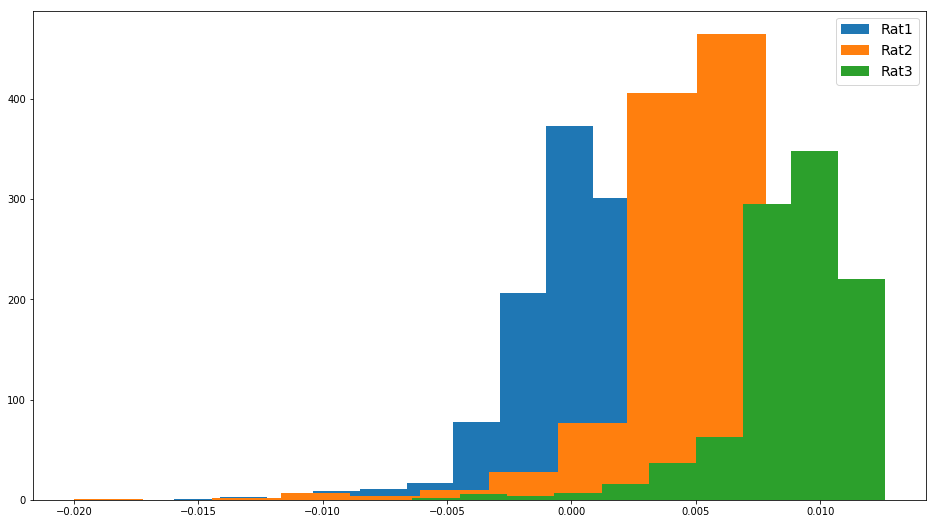

In [291]:
plt.figure(figsize=(16,9))
plt.hist(-1*np.array(list(macronodes_r1.values())), label='Rat1')
plt.hist(-1*np.array(list(macronodes_r2.values())), label='Rat2')
plt.hist(-1*np.array(list(macronodes_r3.values())), label='Rat3')

plt.legend(fontsize=14)
# plt.xlim(0, max(-1*np.array(list(macronodes_r3.values()))))
# plt.savefig("../figs/pngs/RatBrain_CE.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/RatBrain_CE.pdf", bbox_inches='tight')

plt.show()

In [9]:
colors = cols 
pharangeal_neurons = ["I1L","I1R","I2L","I2R","I3","I4","I5","I6",
                      "M1","M2L","M2R","M3L","M3R","M4","M5",
                      "MCL","MCR","MI","NSML","NSMR"]

nonmating_neurons  = ['ALNL','ALNR','AN1a','AN1b','AN2a','AN2b','AVKL','AVKR','DVA' ,'PDEL','PDER',
                      'PHCL','PHCR','PLML','PLMR','PLNL','PLNR','PVDL','PVDR','PVM','PQR',
                      'PVQL','PVQR','PVR','PVWL','PVWR']

other_dumb_neurons = ['intestine', 'anal', 'hyp']

tmus = ['MDL01', 'MDL02', 'MDL03', 'MDL04', 'MDL05', 'MDL06', 
        'MDL07', 'MDL08', 'MDL09', 'MDL10', 'MDL11', 'MDL12',
        'MDL13', 'MDL14', 'MDL15', 'MDL16', 'MDL17', 'MDL18', 
        'MDL19', 'MDL20', 'MDL21', 'MDL22', 'MDL23', 'MDL24', 
        'MDR01', 'MDR02', 'MDR03', 'MDR04', 'MDR05', 'MDR06', 
        'MDR07', 'MDR08', 'MDR09', 'MDR10', 'MDR11', 'MDR12', 
        'MDR13', 'MDR14', 'MDR15', 'MDR16', 'MDR17', 'MDR18', 
        'MDR19', 'MDR20', 'MDR21', 'MDR22', 'MDR23', 'MDR24', 
        'MVL01', 'MVL02', 'MVL03', 'MVL04', 'MVL05', 'MVL06', 
        'MVL07', 'MVL08', 'MVL09', 'MVL10', 'MVL11', 'MVL12', 
        'MVL13', 'MVL14', 'MVL15', 'MVL16', 'MVL17', 'MVL18', 
        'MVL19', 'MVL20', 'MVL21', 'MVL22', 'MVL23', 
        'MVR01', 'MVR02', 'MVR03', 'MVR04', 'MVR05', 'MVR06', 
        'MVR07', 'MVR08', 'MVR09', 'MVR10', 'MVR11', 'MVR12', 
        'MVR13', 'MVR14', 'MVR15', 'MVR16', 'MVR17', 'MVR18', 
        'MVR19', 'MVR20', 'MVR21', 'MVR22', 'MVR23', 'MVR24']

emus = ['dBWML1', 'dBWML2', 'dBWML3', 'dBWML4', 'dBWML5', 'dBWML6', 
        'dBWML7', 'dBWML8', 'dBWML9', 'dBWML10','dBWML11','dBWML12',
        'dBWML13','dBWML14','dBWML15','dBWML16','dBWML17','dBWML18',
        'dBWML19','dBWML20','dBWML21','dBWML22','dBWML23','dBWML24', 
        'dBWMR1', 'dBWMR2', 'dBWMR3', 'dBWMR4', 'dBWMR5', 'dBWMR6', 
        'dBWMR7', 'dBWMR8', 'dBWMR9', 'dBWMR10','dBWMR11','dBWMR12',
        'dBWMR13','dBWMR14','dBWMR15','dBWMR16','dBWMR17','dBWMR18',
        'dBWMR19','dBWMR20','dBWMR21','dBWMR22','dBWMR23','dBWMR24', 
        'vBWML1', 'vBWML2', 'vBWML3', 'vBWML4', 'vBWML5', 'vBWML6', 
        'vBWML7', 'vBWML8', 'vBWML9', 'vBWML10','vBWML11','vBWML12',
        'vBWML13','vBWML14','vBWML15','vBWML16','vBWML18','vBWML17',
        'vBWML19','vBWML20','vBWML21','vBWML22','vBWML23',
        'vBWMR1', 'vBWMR2', 'vBWMR3', 'vBWMR4', 'vBWMR5', 'vBWMR6', 
        'vBWMR7', 'vBWMR8', 'vBWMR9', 'vBWMR10','vBWMR11','vBWMR12',
        'vBWMR13','vBWMR14','vBWMR15','vBWMR16','vBWMR17','vBWMR18',
        'vBWMR19','vBWMR20','vBWMR21','vBWMR22','vBWMR23','vBWMR24']

muscles = dict(zip(emus, tmus))


total_dumb_neurons = list(set(other_dumb_neurons + pharangeal_neurons))
# total_dumb_neurons = list(set(other_dumb_neurons + pharangeal_neurons + hmmmmmm))

fn = "../data/celeg-varshney-natpaperlayout.cyjs"
with open(fn, "r") as read_file:
    data = json.load(read_file)

varshney_node_data = data['elements']['nodes']
varshney_edge_data = data['elements']['edges']

# Varshney node data 
varshney_node_pos  = [(varshney_node_data[i]['position']['x'], 
                    -1*varshney_node_data[i]['position']['y'])   for i in range(len(varshney_node_data))]
varshney_node_label = [varshney_node_data[i]['data']['name']     for i in range(len(varshney_node_data))]
varshney_node_list  = [varshney_node_data[i]['data']['id']       for i in range(len(varshney_node_data))]
varshney_node_funct = [varshney_node_data[i]['data']['Function'] for i in range(len(varshney_node_data))]
varshney_node_id  = list(range(len(varshney_node_list)))
varshney_node_mapping = dict(zip(varshney_node_list, varshney_node_label))

color_mapping = dict(zip(np.unique(varshney_node_funct), colors))
varshney_node_color = [color_mapping[col] for col in varshney_node_funct]
varshney_colordict = dict(zip(varshney_node_label, varshney_node_color))

# Varshney edge data
varshney_edge_list = [(varshney_edge_data[i]['data']['source'], 
                       varshney_edge_data[i]['data']['target']) for i in range(len(varshney_edge_data))]

varshney_edge_list_betterlabels = [(varshney_node_mapping[eij[0]],varshney_node_mapping[eij[1]]) \
                                   for eij in varshney_edge_list]

weird_nodes = ['avfl','avfr','NMJ','VC06']
G_varshney = nx.DiGraph()
varshney_weights = {}
varshney_edgetype = {}
with open("../data/Varshney_herm_full_edgelist.txt", 'r') as f:
    for line in f:
        nodei, nodej, edgetype, weigh = line.strip().split(',')
        varshney_weights[(nodei, nodej)] = weigh
        varshney_edgetype[(nodei, nodej)] = edgetype
        G_varshney.add_edge(nodei, nodej, weight=float(weigh))

# nx.set_edge_attributes(G_varshney, varshney_edgetype, 'edgetype')
G_varshney.remove_nodes_from(weird_nodes)

for nodei, nodej in varshney_edge_list_betterlabels:
    if nodei or nodej not in G_varshney.nodes():
        G_varshney.add_edge(nodei, nodej, weight=1.0)
        
G_cel = G_varshney.copy()

______________________________________